# Análisis Exploratorio de Datos (EDA)

Este notebook se encarga del Análisis Exploratorio de Datos (EDA).

## Objetivos
**Datos:** Cargados desde Cargar_datos.ipynb
 
Este notebook realiza el análisis exploratorio completo de los datos:
1. Limpieza inicial y unificación de nulos
2. Conversión de tipos de datos
3. Análisis univariado (estadísticos y gráficos)
4. Análisis bivariado vs variable objetivo (default)
5. Análisis multivariado (correlaciones)
6. Conclusiones y transformaciones propuestas

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [15]:
# Configuración de visualización
#pd.set_option('display.max_columns', None)
#pd.set_option('display.float_format', '{:.4f}'.format)
#plt.style.use('seaborn-v0_8-whitegrid')
#sns.set_palette("viridis")
#sns.set_context("notebook", font_scale=1.1)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    style="whitegrid",
    context="talk",
    palette="deep"
)

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titleweight"] = "bold"


In [16]:
# ============================================
# 1. CARGAR DATOS PROCESADOS
# ============================================

# Rutas portables
PROJECT_ROOT = Path.cwd()
DATA_INTERIM = PROJECT_ROOT / 'data' / 'interim'
FILE_PKL = DATA_INTERIM / 'creditos_limpio.pkl'

if FILE_PKL.exists():
    df = pd.read_pickle(FILE_PKL)
    print(f"✓ Datos cargados: {df.shape}")
else:
    raise FileNotFoundError("Ejecuta primero Cargar_datos.ipynb")

✓ Datos cargados: (10763, 23)


## 2. Identificación de Tipos de Variables

In [17]:
# Clasificar columnas por tipo de dato
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identificar variable objetivo (Pago_atiempo para estos datos)
if 'Pago_atiempo' in df.columns:
    target = 'Pago_atiempo'
    print(f"Variable objetivo identificada: {target}")
else:
    target = None
    print("ADVERTENCIA: No se encontró variable 'Pago_atiempo'")

print(f"\nVariables numéricas ({len(num_cols)}): {num_cols}")
print(f"Variables categóricas ({len(cat_cols)}): {cat_cols}")

if target:
    print(f"\nDistribución de {target}:")
    print(df[target].value_counts())
    print(f"Tasa de incumplimiento: {df[target].mean():.2%}")

Variable objetivo identificada: Pago_atiempo

Variables numéricas (20): ['tipo_credito', 'capital_prestado', 'plazo_meses', 'edad_cliente', 'salario_cliente', 'total_otros_prestamos', 'cuota_pactada', 'puntaje', 'puntaje_datacredito', 'cant_creditosvigentes', 'huella_consulta', 'saldo_mora', 'saldo_total', 'saldo_principal', 'saldo_mora_codeudor', 'creditos_sectorFinanciero', 'creditos_sectorCooperativo', 'creditos_sectorReal', 'promedio_ingresos_datacredito', 'Pago_atiempo']
Variables categóricas (2): ['tipo_laboral', 'tendencia_ingresos']

Distribución de Pago_atiempo:
Pago_atiempo
1    10252
0      511
Name: count, dtype: int64
Tasa de incumplimiento: 95.25%


In [18]:

# Validación de calidad de datos
def validate_data_quality(df):
    issues = []
    
    # Verificar duplicados
    if df.duplicated().sum() > 0:
        issues.append(f"Duplicados: {df.duplicated().sum()} filas")
    
    # Verificar nulos excesivos
    high_null = df.columns[df.isnull().mean() > 0.5].tolist()
    if high_null:
        issues.append(f"Columnas con >50% nulos: {high_null}")
    
    # Verificar cardinalidad en categóricas
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].nunique() > 100:
            issues.append(f"Alta cardinalidad en {col}: {df[col].nunique()} valores únicos")
    
    return issues

issues = validate_data_quality(df)
if issues:
    print(" PROBLEMAS DETECTADOS:")
    for issue in issues:
        print(f"  • {issue}")
else:
    print("*** Calidad de datos aceptable ***")

*** Calidad de datos aceptable ***


## 3. Limpieza Inicial de Datos


In [19]:
# Unificar representación de valores nulos
null_forms = ['NA', 'N/A', 'null', 'NULL', 'None', '', ' ', '-', '?']
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].replace(null_forms, np.nan)
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip()

# Convertir tipos de datos para optimización
for col in df.columns:
    if col in cat_cols:
        df[col] = df[col].astype('category')
    elif col in num_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Reporte de nulos después de limpieza
print("VALORES NULOS POR COLUMNA:")
null_report = df.isnull().sum()
print(null_report[null_report > 0] if any(null_report > 0) else "No hay valores nulos")


VALORES NULOS POR COLUMNA:
puntaje_datacredito                 6
saldo_mora                        156
saldo_total                       156
saldo_principal                   405
saldo_mora_codeudor               590
promedio_ingresos_datacredito    2930
tendencia_ingresos               2990
dtype: int64


## 4. Análisis Univariado

ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
                                 count          mean           std        min  \
tipo_credito                   10763.0  5.411100e+00  2.338300e+00       4.00   
capital_prestado               10763.0  2.434315e+06  1.909643e+06  360000.00   
plazo_meses                    10763.0  1.057560e+01  6.632100e+00       2.00   
edad_cliente                   10763.0  4.394860e+01  1.506090e+01      19.00   
salario_cliente                10763.0  1.721643e+07  3.554767e+08       0.00   
total_otros_prestamos          10763.0  6.238870e+06  1.184183e+08       0.00   
cuota_pactada                  10763.0  2.436174e+05  2.104937e+05   23944.00   
puntaje                        10763.0  9.117000e+01  1.646540e+01     -38.01   
puntaje_datacredito            10757.0  7.807908e+02  1.048780e+02      -7.00   
cant_creditosvigentes          10763.0  5.726700e+00  3.977200e+00       0.00   
huella_consulta                10763.0  4.228600e+00  3.06470

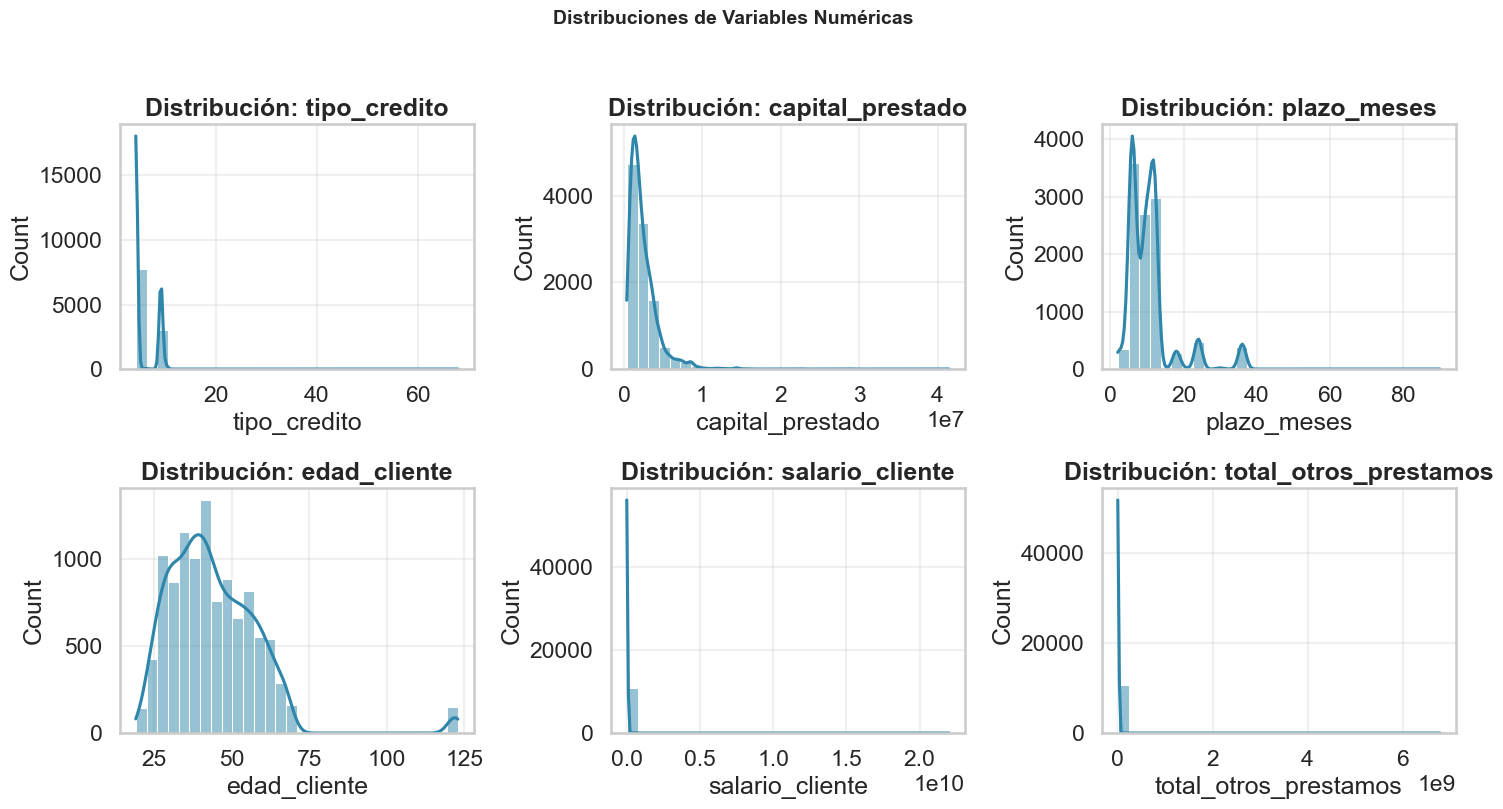


FRECUENCIAS - VARIABLES CATEGÓRICAS

TIPO_LABORAL:
tipo_laboral
Empleado         6754
Independiente    4009
Name: count, dtype: int64

TENDENCIA_INGRESOS:
tendencia_ingresos
Creciente      5294
NaN            2990
Decreciente    1291
Estable        1188
Name: count, dtype: int64


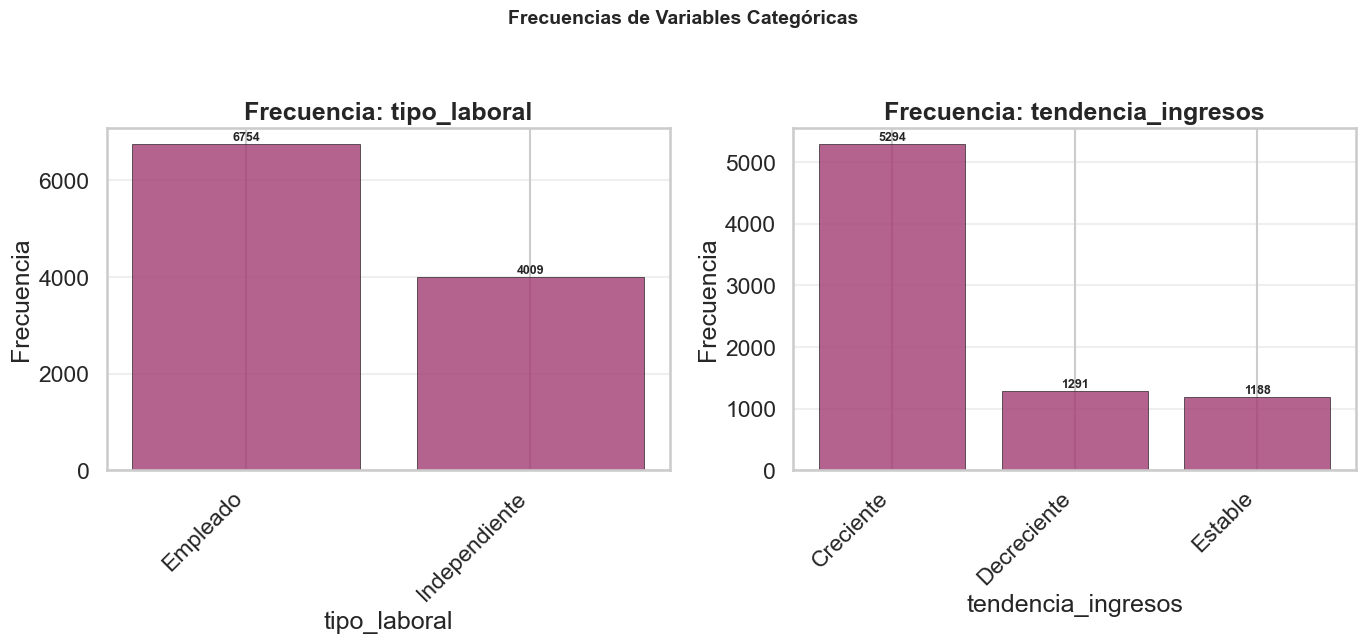

In [20]:
# 4.1 Estadísticas descriptivas para variables numéricas
if num_cols:
    print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
    print("=" * 50)
    desc_stats = df[num_cols].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
    desc_stats['skew'] = df[num_cols].skew()
    desc_stats['missing_%'] = (df[num_cols].isnull().sum() / len(df)) * 100
    print(desc_stats.round(4))

# 4.2 Distribuciones de variables numéricas
if len(num_cols) > 0:
    n_plots = min(6, len(num_cols))
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, col in enumerate(num_cols[:n_plots]):
        ax = axes[i]
        sns.histplot(df[col].dropna(), kde=True, ax=ax, bins=30, color='#2E86AB')
        ax.set_title(f'Distribución: {col}', fontweight='bold')
        ax.set_xlabel(col)
        ax.grid(True, alpha=0.3)
    
    # Ocultar subplots vacíos
    for i in range(n_plots, 6):
        axes[i].set_visible(False)
    
    plt.suptitle('Distribuciones de Variables Numéricas', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# 4.3 Frecuencias para variables categóricas
if cat_cols:
    print("\n" + "=" * 50)
    print("FRECUENCIAS - VARIABLES CATEGÓRICAS")
    print("=" * 50)
    for col in cat_cols:
        print(f"\n{col.upper()}:")
        print(df[col].value_counts(dropna=False))

# 4.4 Gráficos de barras para categóricas
if len(cat_cols) > 0:
    n_plots = min(4, len(cat_cols))
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(cat_cols[:n_plots]):
        ax = axes[i]
        value_counts = df[col].value_counts().sort_values(ascending=False)
        bars = ax.bar(range(len(value_counts)), value_counts.values, color='#A23B72', alpha=0.8, edgecolor='black', linewidth=0.5)
        ax.set_title(f'Frecuencia: {col}', fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Agregar etiquetas de valor
        for bar, val in zip(bars, value_counts.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(val), ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Ocultar subplots vacíos
    for i in range(n_plots, 4):
        axes[i].set_visible(False)
    
    plt.suptitle('Frecuencias de Variables Categóricas', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [21]:
def detectar_outliers_iqr(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return serie[(serie < lower) | (serie > upper)]


Variables numéricas: Index(['tipo_credito', 'capital_prestado', 'plazo_meses', 'edad_cliente',
       'salario_cliente', 'total_otros_prestamos', 'cuota_pactada', 'puntaje',
       'puntaje_datacredito', 'cant_creditosvigentes', 'huella_consulta',
       'saldo_mora', 'saldo_total', 'saldo_principal', 'saldo_mora_codeudor',
       'creditos_sectorFinanciero', 'creditos_sectorCooperativo',
       'creditos_sectorReal', 'promedio_ingresos_datacredito', 'Pago_atiempo'],
      dtype='object')


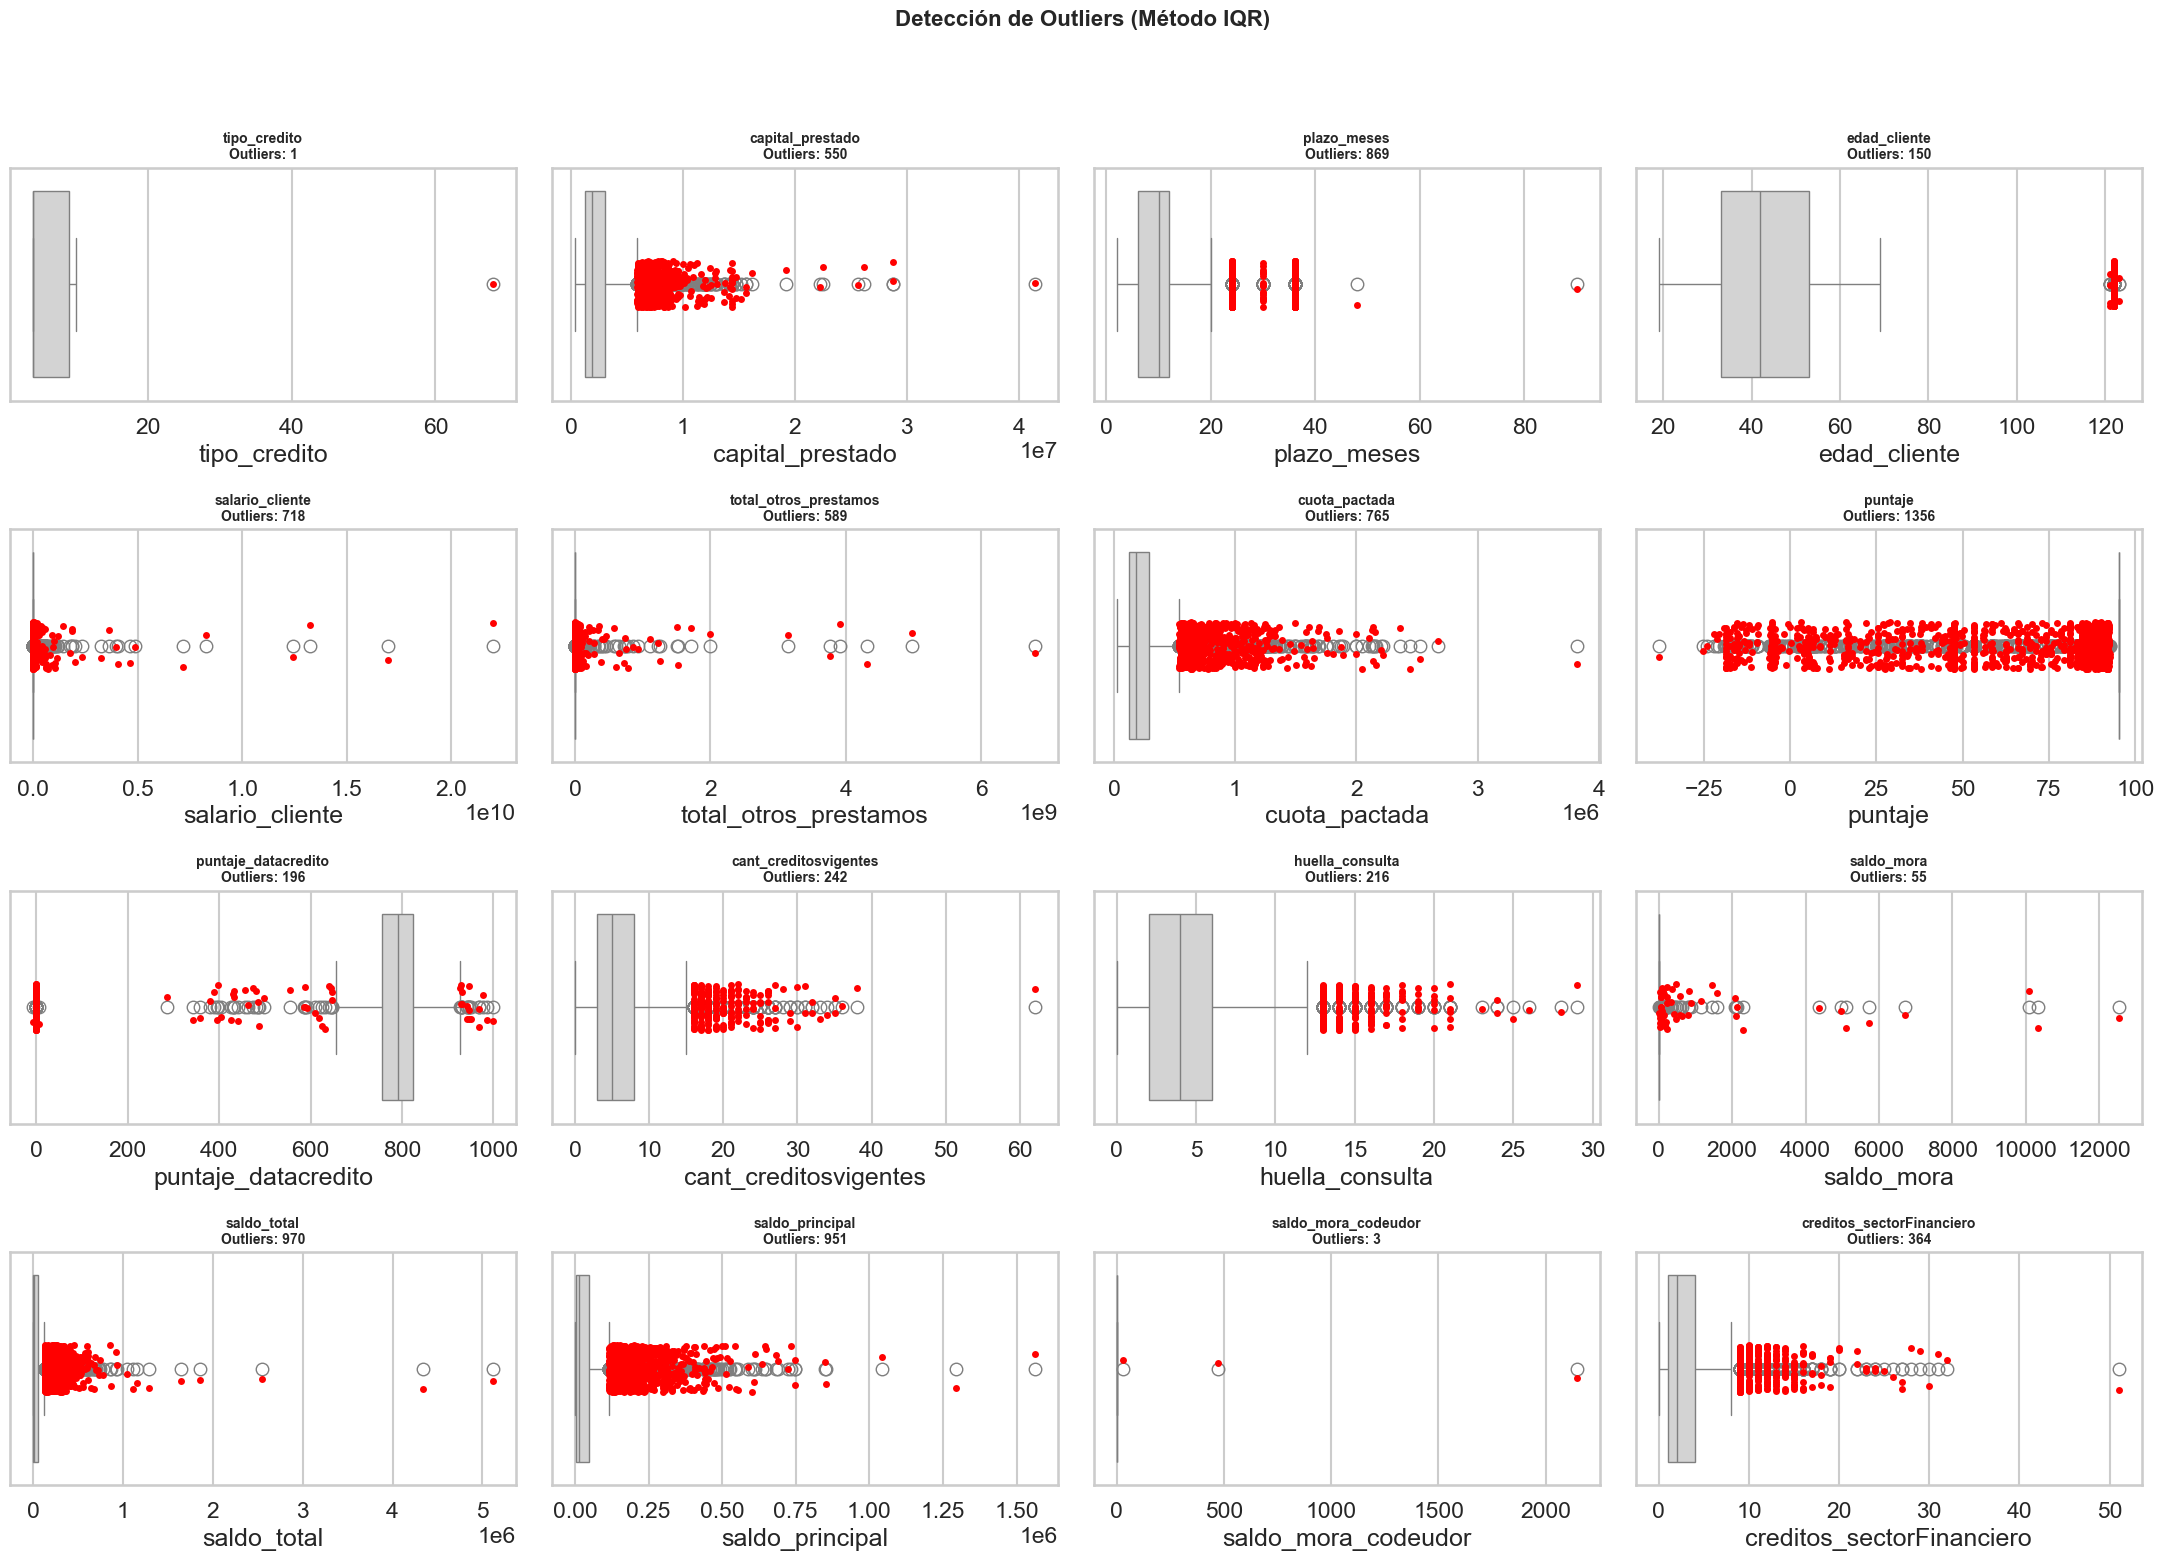

In [22]:
variables_numericas = df.select_dtypes(include="number").columns
print("Variables numéricas:", variables_numericas)

# Número de subplots
n_filas = 4
n_columnas = 4
max_vars = n_filas * n_columnas

fig, axes = plt.subplots(n_filas, n_columnas, figsize=(22, 16))
axes = axes.flatten()

for i, col in enumerate(variables_numericas[:max_vars]):
    outliers_var = detectar_outliers_iqr(df[col])

    sns.boxplot(
        x=df[col],
        ax=axes[i],
        color="lightgray"
    )

    sns.stripplot(
        x=outliers_var,
        ax=axes[i],
        color="red",
        size=5,
        jitter=True
    )

    axes[i].set_title(
        f"{col}\nOutliers: {len(outliers_var)}",
        fontsize=10
    )

# Ocultar subplots vacíos si hay menos de 10 variables
for j in range(i + 1, max_vars):
    fig.delaxes(axes[j])

plt.suptitle(
    "Detección de Outliers (Método IQR)",
    fontsize=16,
    fontweight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


###  ANÁLISIS CRÍTICO: DESBALANCE DE CLASES

**PROBLEMA MÁS IMPORTANTE DEL DATASET**

El desbalance de clases ocurre cuando una categoría de la variable objetivo tiene muchos más ejemplos que otra. Esto causa que los modelos de ML:
- Predigan siempre la clase mayoritaria
- Ignoren la clase minoritaria (que suele ser la más importante)
- Generen métricas engañosas (alta accuracy sin aprender nada)

En problemas de riesgo crediticio, la clase minoritaria (NO pagó) es la MÁS IMPORTANTE de detectar.

In [25]:
# ============================================
#    ANÁLISIS ESTADÍSTICO DEL DESBALANCE
# ============================================

print("="*80)
print(" ANÁLISIS DE DESBALANCE EN VARIABLE OBJETIVO: Pago_atiempo")
print("="*80)

# Verificar que existe la columna
if 'Pago_atiempo' not in df.columns:
    print("X ERROR: Columna 'Pago_atiempo' no encontrada")
    print(f"Columnas disponibles: {list(df.columns)}")
else:
    # Contar frecuencias
    target_counts = df['Pago_atiempo'].value_counts().sort_index()
    target_pct = (target_counts / len(df) * 100).round(2)
    
    # Mostrar resultados
    print(f"\n DISTRIBUCIÓN DE CLASES:")
    print(f"   Clase 0 (No pagó a tiempo):  {target_counts[0]:>6,} registros ({target_pct[0]:>5.2f}%)")
    print(f"   Clase 1 (Sí pagó a tiempo):  {target_counts[1]:>6,} registros ({target_pct[1]:>5.2f}%)")
    print(f"   " + "-"*60)
    print(f"   Total:                        {len(df):>6,} registros (100.00%)")
    
    # Calcular ratio de desbalance
    ratio = target_counts[1] / target_counts[0]
    print(f"\n MÉTRICAS DE DESBALANCE:")
    print(f"   Ratio de desbalance:          {ratio:.2f} : 1")
    print(f"   Clase mayoritaria:            Pagó a tiempo (1)")
    print(f"   Clase minoritaria:            No pagó a tiempo (0)")
    print(f"   Diferencia absoluta:          {target_counts[1] - target_counts[0]:,} registros")
    
    # Interpretación del desbalance
    print(f"\n🔍 INTERPRETACIÓN:")
    if ratio >= 20:
        nivel = "EXTREMO"
        color_nivel = "🔴"
    elif ratio >= 10:
        nivel = "SEVERO"
        color_nivel = "🟠"
    elif ratio >= 5:
        nivel = "MODERADO"
        color_nivel = "🟡"
    else:
        nivel = "LEVE"
        color_nivel = "🟢"
    
    print(f"   {color_nivel} Nivel de desbalance:       {nivel}")
    print(f"   Por cada cliente que NO pagó, hay {ratio:.1f} que SÍ pagaron")
    
    if ratio >= 10:
        print(f"\n     ALERTA: Este nivel de desbalance es CRÍTICO")
        print(f"   El modelo de ML tendrá SERIOS problemas sin técnicas de balanceo")
    
    print("\n" + "="*80)

 ANÁLISIS DE DESBALANCE EN VARIABLE OBJETIVO: Pago_atiempo

 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No pagó a tiempo):     511 registros ( 4.75%)
   Clase 1 (Sí pagó a tiempo):  10,252 registros (95.25%)
   ------------------------------------------------------------
   Total:                        10,763 registros (100.00%)

 MÉTRICAS DE DESBALANCE:
   Ratio de desbalance:          20.06 : 1
   Clase mayoritaria:            Pagó a tiempo (1)
   Clase minoritaria:            No pagó a tiempo (0)
   Diferencia absoluta:          9,741 registros

🔍 INTERPRETACIÓN:
   🔴 Nivel de desbalance:       EXTREMO
   Por cada cliente que NO pagó, hay 20.1 que SÍ pagaron

     ALERTA: Este nivel de desbalance es CRÍTICO
   El modelo de ML tendrá SERIOS problemas sin técnicas de balanceo



C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3560370612.py:103: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axes[1, 1].add_patch(plt.Rectangle((0, 0), 1, 1, color=colors[0],
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3560370612.py:115: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axes[1, 1].add_patch(plt.Rectangle((2 + col*0.9, row*0.9), 0.8, 0.8,


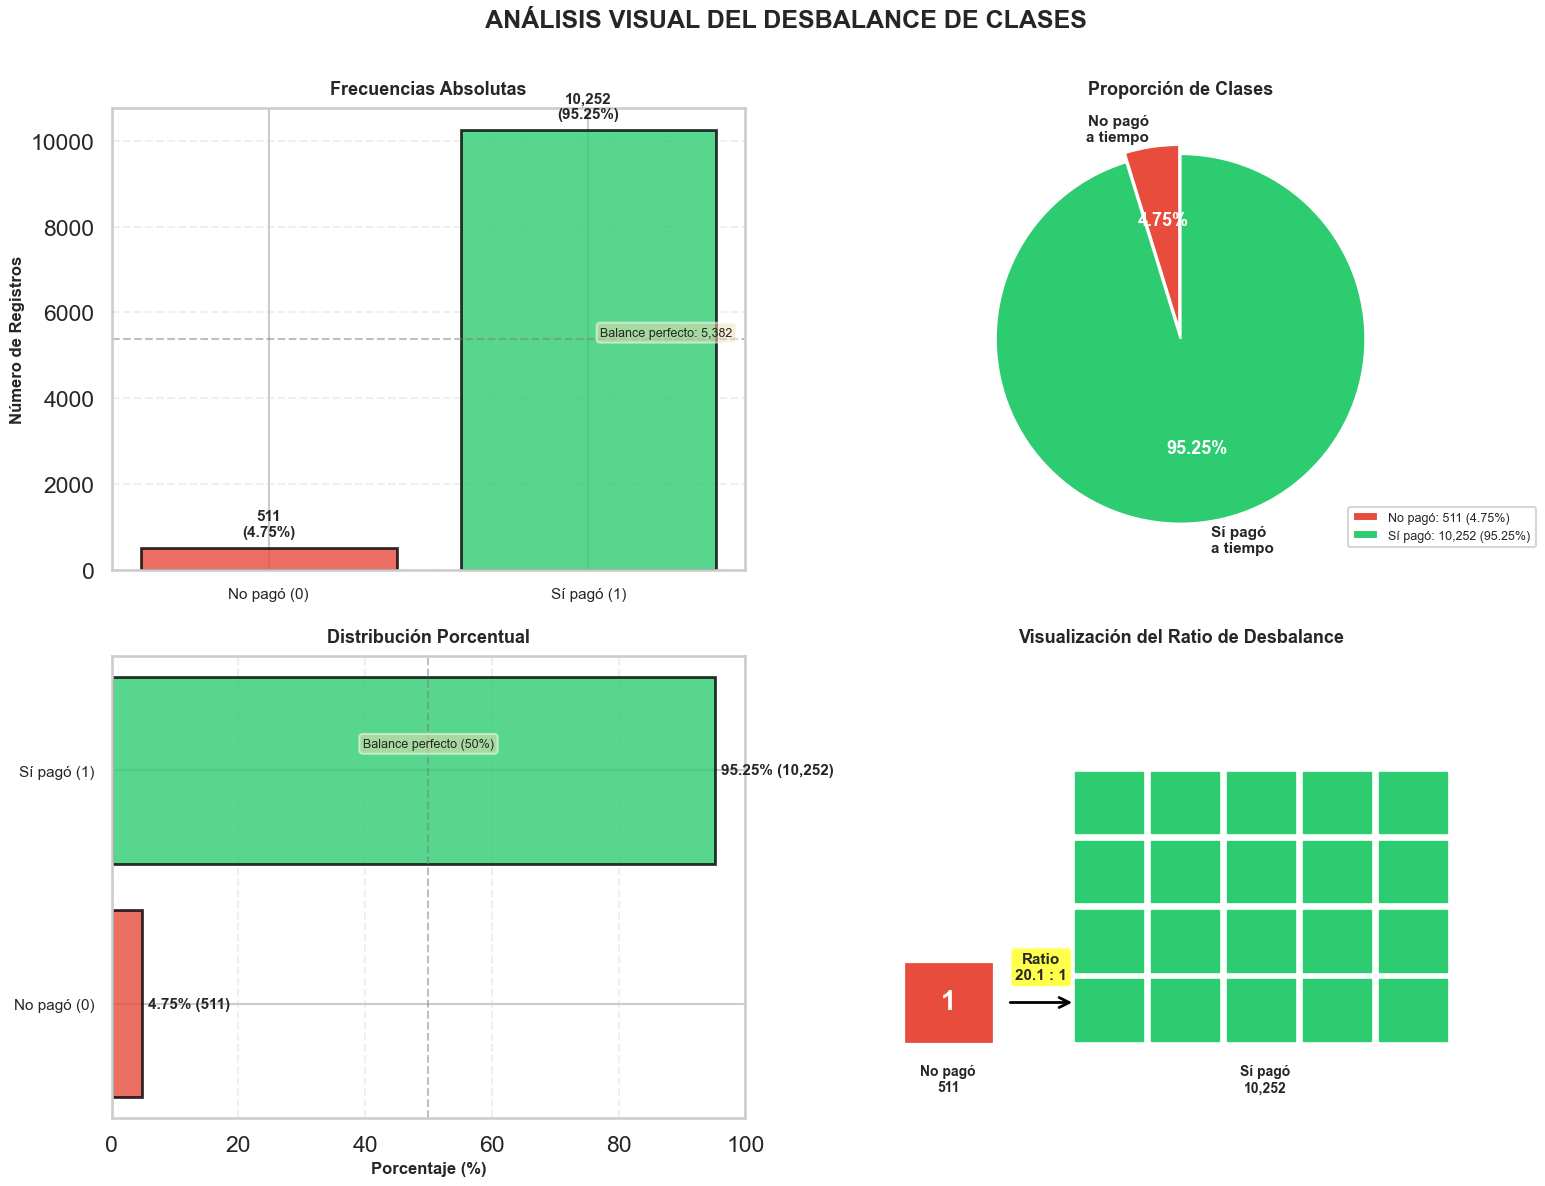

In [27]:
# ============================================
#       VISUALIZACIÓN DEL DESBALANCE
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(' ANÁLISIS VISUAL DEL DESBALANCE DE CLASES', 
            fontsize=18, fontweight='bold', y=0.995)

# Colores
colors = ['#e74c3c', '#2ecc71']  # Rojo para No pagó, Verde para Sí pagó

# ============================================
# GRÁFICO 1: Barras Verticales con Frecuencias
# ============================================
bars = axes[0, 0].bar(range(len(target_counts)), target_counts.values, 
                    color=colors, edgecolor='black', alpha=0.8, linewidth=2)
axes[0, 0].set_xticks(range(len(target_counts)))
axes[0, 0].set_xticklabels(['No pagó (0)', 'Sí pagó (1)'], fontsize=11)
axes[0, 0].set_ylabel('Número de Registros', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Frecuencias Absolutas', fontsize=13, fontweight='bold', pad=10)
axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')

# Añadir etiquetas de valor y porcentaje
for i, (bar, count, pct) in enumerate(zip(bars, target_counts.values, target_pct.values)):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, height + 200,
                    f'{count:,}\n({pct}%)',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# Añadir línea horizontal promedio
avg = len(df) / 2
axes[0, 0].axhline(avg, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
axes[0, 0].text(0.98, avg, f'Balance perfecto: {avg:,.0f}', 
                transform=axes[0, 0].get_yaxis_transform(),
                ha='right', va='bottom', fontsize=9, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ============================================
# GRÁFICO 2: Pie Chart con Porcentajes
# ============================================
wedges, texts, autotexts = axes[0, 1].pie(
    target_counts.values, 
    labels=['No pagó\na tiempo', 'Sí pagó\na tiempo'],
    autopct='%1.2f%%',
    colors=colors, 
    startangle=90,
    textprops={'fontsize': 11, 'fontweight': 'bold'},
    explode=(0.05, 0)  # Separar un poco la clase minoritaria
)

# Mejorar estilo del texto
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)

axes[0, 1].set_title('Proporción de Clases', fontsize=13, fontweight='bold', pad=10)

# Añadir leyenda con información adicional
axes[0, 1].legend(
    [f'No pagó: {target_counts[0]:,} ({target_pct[0]}%)',
    f'Sí pagó: {target_counts[1]:,} ({target_pct[1]}%)'],
    loc='upper left',
    bbox_to_anchor=(0.85, 0.15),
    fontsize=9
)

# ============================================
# GRÁFICO 3: Barras Horizontales con Comparación
# ============================================
y_pos = np.arange(len(target_pct))
bars_h = axes[1, 0].barh(y_pos, target_pct.values, color=colors, 
                        edgecolor='black', alpha=0.8, linewidth=2)
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(['No pagó (0)', 'Sí pagó (1)'], fontsize=11)
axes[1, 0].set_xlabel('Porcentaje (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Distribución Porcentual', fontsize=13, fontweight='bold', pad=10)
axes[1, 0].grid(axis='x', alpha=0.3, linestyle='--')

# Etiquetas de porcentaje
for i, (bar, pct, count) in enumerate(zip(bars_h, target_pct.values, target_counts.values)):
    width = bar.get_width()
    axes[1, 0].text(width + 1, bar.get_y() + bar.get_height()/2,
                    f'{pct}% ({count:,})',
                    va='center', fontsize=11, fontweight='bold')

# Línea vertical en 50%
axes[1, 0].axvline(50, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
axes[1, 0].text(50, 1.1, 'Balance perfecto (50%)', 
                ha='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ============================================
# GRÁFICO 4: Comparación Visual del Ratio
# ============================================
# Crear visualización de ratio con cuadrados
ratio_val = target_counts[1] / target_counts[0]

# Clase minoritaria (1 cuadrado)
axes[1, 1].add_patch(plt.Rectangle((0, 0), 1, 1, color=colors[0], 
                                    edgecolor='black', linewidth=2))
axes[1, 1].text(0.5, 0.5, '1', ha='center', va='center', 
                fontsize=20, fontweight='bold', color='white')
axes[1, 1].text(0.5, -0.3, f'No pagó\n{target_counts[0]:,}', 
                ha='center', va='top', fontsize=10, fontweight='bold')

# Clase mayoritaria (múltiples cuadrados)
num_squares = min(int(ratio_val), 25)  # Limitar para visualización
for i in range(num_squares):
    row = i // 5
    col = i % 5
    axes[1, 1].add_patch(plt.Rectangle((2 + col*0.9, row*0.9), 0.8, 0.8, 
                                        color=colors[1], edgecolor='black', linewidth=1))

axes[1, 1].text(4.25, -0.3, f'Sí pagó\n{target_counts[1]:,}', 
                ha='center', va='top', fontsize=10, fontweight='bold')

# Flecha y texto de ratio
axes[1, 1].annotate('', xy=(2, 0.5), xytext=(1.2, 0.5),
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
axes[1, 1].text(1.6, 0.8, f'Ratio\n{ratio_val:.1f} : 1', 
                ha='center', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

axes[1, 1].set_xlim(-0.5, 7)
axes[1, 1].set_ylim(-1, 5)
axes[1, 1].axis('off')
axes[1, 1].set_title('Visualización del Ratio de Desbalance', 
                    fontsize=13, fontweight='bold', pad=10)

# Ajustar diseño
plt.tight_layout()
plt.show()


In [28]:
# ============================================
#     IMPACTO DEL DESBALANCE EN MÉTRICAS
# ============================================

print("="*80)
print(" SIMULACIÓN: IMPACTO DEL DESBALANCE EN MODELOS")
print("="*80)

# Calcular accuracy de un modelo "tonto" que siempre predice la clase mayoritaria
baseline_accuracy = target_pct[1] / 100

print(f"\n ESCENARIO: Modelo que SIEMPRE predice 'Sí pagó' (1)")
print(f"   Accuracy:                     {baseline_accuracy*100:.2f}%")
print(f"   Precision (clase 1):          {baseline_accuracy*100:.2f}%")
print(f"   Recall (clase 1):             100.00%")
print(f"   Recall (clase 0):             0.00%  ← ¡NO detecta NINGÚN default!")

print(f"\n  INTERPRETACIÓN:")
print(f"   Un modelo SIN APRENDER NADA puede lograr {baseline_accuracy*100:.1f}% de accuracy")
print(f"   simplemente prediciendo siempre la clase mayoritaria.")
print(f"")
print(f"   Esto significa que:")
print(f"   • Accuracy NO es una buena métrica para este problema")
print(f"   • Necesitamos enfocarnos en detectar la clase 0 (No pagó)")
print(f"   • Debemos usar métricas que penalicen falsos negativos")

# Calcular costo de errores
total_clientes = len(df)
clientes_no_pagan = target_counts[0]
perdida_por_default = 1000000  # Ejemplo: 1 millón de pesos por crédito impago

print(f"\n ANÁLISIS DE COSTO DE ERRORES (Ejemplo):")
print(f"   Si NO detectamos a un cliente que NO pagará:")
print(f"   • Pérdida estimada: ${perdida_por_default:,} por crédito")
print(f"   • Total clientes que no pagan: {clientes_no_pagan:,}")
print(f"   • Pérdida potencial total: ${perdida_por_default * clientes_no_pagan:,}")
print(f"")
print(f"   Si RECHAZAMOS a un cliente que SÍ pagaría:")
print(f"   • Pérdida: Costo de oportunidad (menor impacto)")
print(f"")
print(f"     CONCLUSIÓN: Los Falsos Negativos son MÁS COSTOSOS")

print("\n" + "="*80)

 SIMULACIÓN: IMPACTO DEL DESBALANCE EN MODELOS

 ESCENARIO: Modelo que SIEMPRE predice 'Sí pagó' (1)
   Accuracy:                     95.25%
   Precision (clase 1):          95.25%
   Recall (clase 1):             100.00%
   Recall (clase 0):             0.00%  ← ¡NO detecta NINGÚN default!

  INTERPRETACIÓN:
   Un modelo SIN APRENDER NADA puede lograr 95.2% de accuracy
   simplemente prediciendo siempre la clase mayoritaria.

   Esto significa que:
   • Accuracy NO es una buena métrica para este problema
   • Necesitamos enfocarnos en detectar la clase 0 (No pagó)
   • Debemos usar métricas que penalicen falsos negativos

 ANÁLISIS DE COSTO DE ERRORES (Ejemplo):
   Si NO detectamos a un cliente que NO pagará:
   • Pérdida estimada: $1,000,000 por crédito
   • Total clientes que no pagan: 511
   • Pérdida potencial total: $511,000,000

   Si RECHAZAMOS a un cliente que SÍ pagaría:
   • Pérdida: Costo de oportunidad (menor impacto)

     CONCLUSIÓN: Los Falsos Negativos son MÁS COSTOSOS

In [29]:
# ============================================
#    ESTRATEGIAS PARA MANEJAR EL DESBALANCE
# ============================================

print("="*80)
print(" ESTRATEGIAS REQUERIDAS PARA EL AVANCE-2 (Modelamiento)")
print("="*80)

print(f"\n 1. TÉCNICAS DE RE-MUESTREO:")
print(f"")
print(f"   A. OVERSAMPLING (Aumentar clase minoritaria):")
print(f"      • SMOTE (Synthetic Minority Over-sampling Technique)")
print(f"        - Crea ejemplos sintéticos de la clase minoritaria")
print(f"        - Más robusto que duplicar registros")
print(f"        - Recomendado para este caso")
print(f"")
print(f"      • ADASYN (Adaptive Synthetic Sampling)")
print(f"        - Similar a SMOTE pero más adaptativo")
print(f"        - Genera más ejemplos en regiones difíciles")
print(f"")
print(f"   B. UNDERSAMPLING (Reducir clase mayoritaria):")
print(f"      • RandomUnderSampler")
print(f"        - Elimina aleatoriamente ejemplos de clase mayoritaria")
print(f"        - RIESGO: Pérdida de información importante")
print(f"")
print(f"   C. COMBINADO:")
print(f"      • SMOTEENN o SMOTETomek")
print(f"        - Combina oversampling y limpieza de ejemplos ambiguos")
print(f"        - Mejor calidad de datos")

print(f"\n 2. AJUSTE DE PESOS DE CLASE:")
print(f"")
print(f"   • Usar parámetro 'class_weight' en modelos:")
print(f"     - LogisticRegression(class_weight='balanced')")
print(f"     - RandomForest(class_weight='balanced')")
print(f"     - SVC(class_weight='balanced')")
print(f"")
print(f"   • Peso manual calculado:")
ratio_weight = len(df) / (2 * target_counts[0])
print(f"     - Clase 0 (No pagó): peso = {ratio_weight:.2f}")
print(f"     - Clase 1 (Sí pagó):  peso = 1.00")

print(f"\n 3. MÉTRICAS APROPIADAS:")
print(f"")
print(f"   X NO USAR:")
print(f"      • Accuracy (engañosa con desbalance)")
print(f"")
print(f"    SÍ USAR:")
print(f"      • Precision: De los que predigo como 0, ¿cuántos son realmente 0?")
print(f"      • Recall: De todos los 0 reales, ¿cuántos detecto?")
print(f"      • F1-Score: Balance entre Precision y Recall")
print(f"      • AUC-ROC: Área bajo la curva ROC")
print(f"      • AUC-PR: Área bajo curva Precision-Recall (mejor para desbalance)")
print(f"      • Matriz de Confusión: Ver tipos de errores")
print(f"")
print(f"    ENFOQUE:")
print(f"      • Maximizar RECALL de clase 0 (detectar defaults)")
print(f"      • Mantener PRECISION razonable (no rechazar a todos)")

print(f"\n 4. VALIDACIÓN CRUZADA ESTRATIFICADA:")
print(f"")
print(f"   • Usar StratifiedKFold en lugar de KFold")
print(f"   • Mantiene la proporción de clases en cada fold")
print(f"   • Evita folds sin ejemplos de clase minoritaria")

print(f"\n 5. THRESHOLD TUNING:")
print(f"")
print(f"   • Ajustar umbral de decisión (default = 0.5)")
print(f"   • Reducir threshold para detectar más clase 0")
print(f"   • Ejemplo: threshold = 0.3")
print(f"     - Si P(No pagó) > 0.3 → Predecir 'No pagó'")

print("\n" + "="*80)
print("✓ Estrategias documentadas para implementación en Avance-2")
print("="*80)

 ESTRATEGIAS REQUERIDAS PARA EL AVANCE-2 (Modelamiento)

 1. TÉCNICAS DE RE-MUESTREO:

   A. OVERSAMPLING (Aumentar clase minoritaria):
      • SMOTE (Synthetic Minority Over-sampling Technique)
        - Crea ejemplos sintéticos de la clase minoritaria
        - Más robusto que duplicar registros
        - Recomendado para este caso

      • ADASYN (Adaptive Synthetic Sampling)
        - Similar a SMOTE pero más adaptativo
        - Genera más ejemplos en regiones difíciles

   B. UNDERSAMPLING (Reducir clase mayoritaria):
      • RandomUnderSampler
        - Elimina aleatoriamente ejemplos de clase mayoritaria
        - RIESGO: Pérdida de información importante

   C. COMBINADO:
      • SMOTEENN o SMOTETomek
        - Combina oversampling y limpieza de ejemplos ambiguos
        - Mejor calidad de datos

 2. AJUSTE DE PESOS DE CLASE:

   • Usar parámetro 'class_weight' en modelos:
     - LogisticRegression(class_weight='balanced')
     - RandomForest(class_weight='balanced')
     - SV

## 5. Análisis Bivariado vs Variable Objetivo (Pago_atiempo)


5. ANÁLISIS BIVARIADO VS PAGO_ATIEMPO
Variable objetivo: 'Pago_atiempo'

TASA GLOBAL DE INCUMPLIMIENTO: 95.25%
Distribución: Pago a tiempo: 4.75%, Incumplimiento: 95.25%

Variables numéricas a analizar: ['tipo_credito', 'capital_prestado', 'plazo_meses', 'edad_cliente', 'salario_cliente']...


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3261975192.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=['#2E86AB', '#A23B72'], ax=ax)
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3261975192.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=['#2E86AB', '#A23B72'], ax=ax)
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3261975192.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=['#2E86AB', '#A23B72'], ax=ax)
C:\Users\USER\Ap

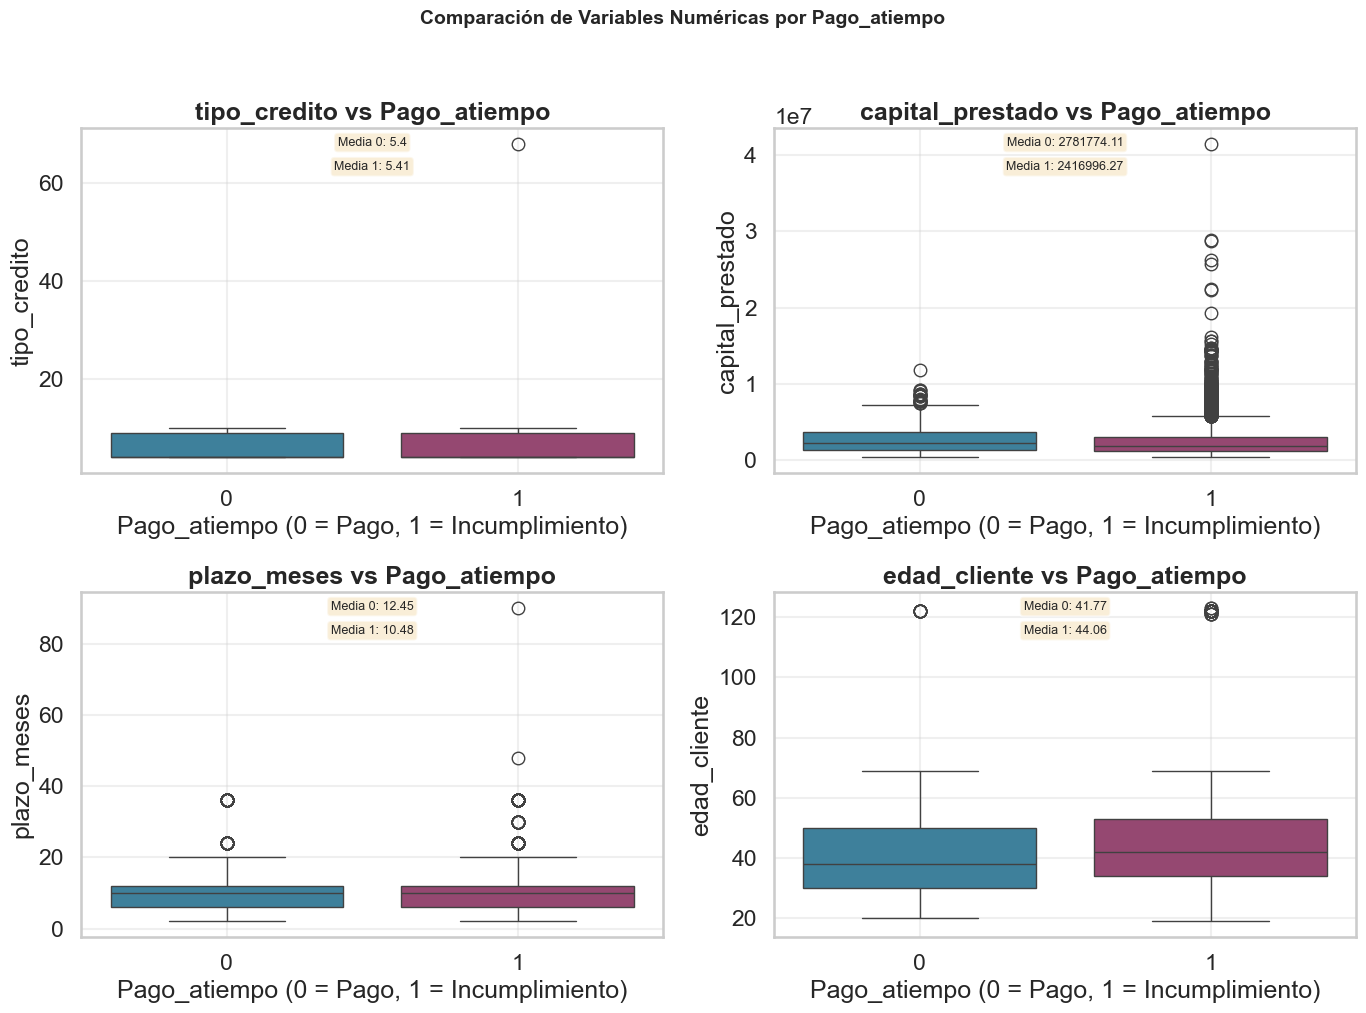

C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3261975192.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target, y=col, data=df, palette=['#2E86AB', '#A23B72'],
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3261975192.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target, y=col, data=df, palette=['#2E86AB', '#A23B72'],


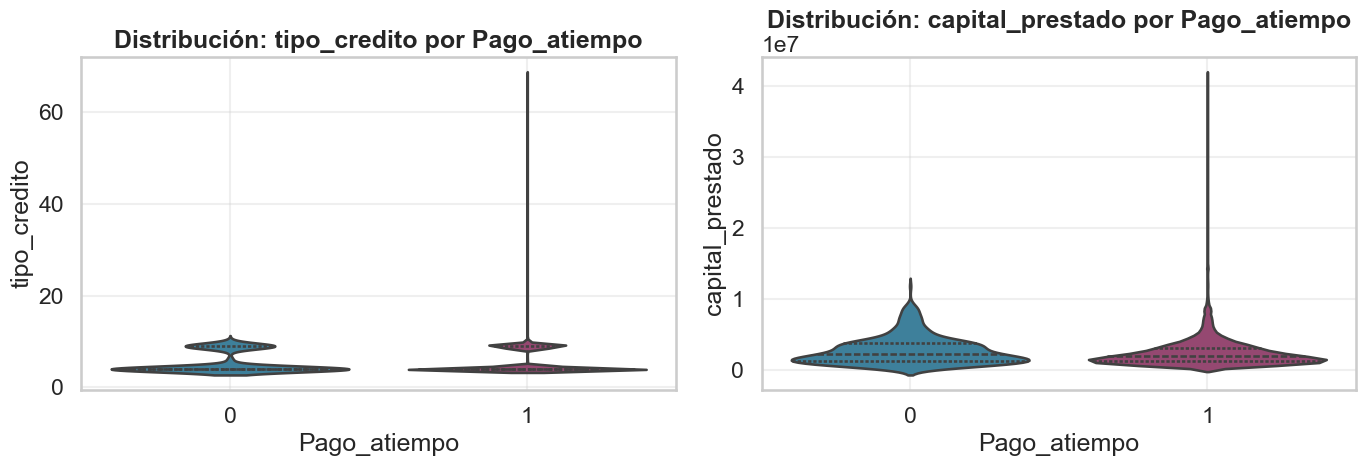

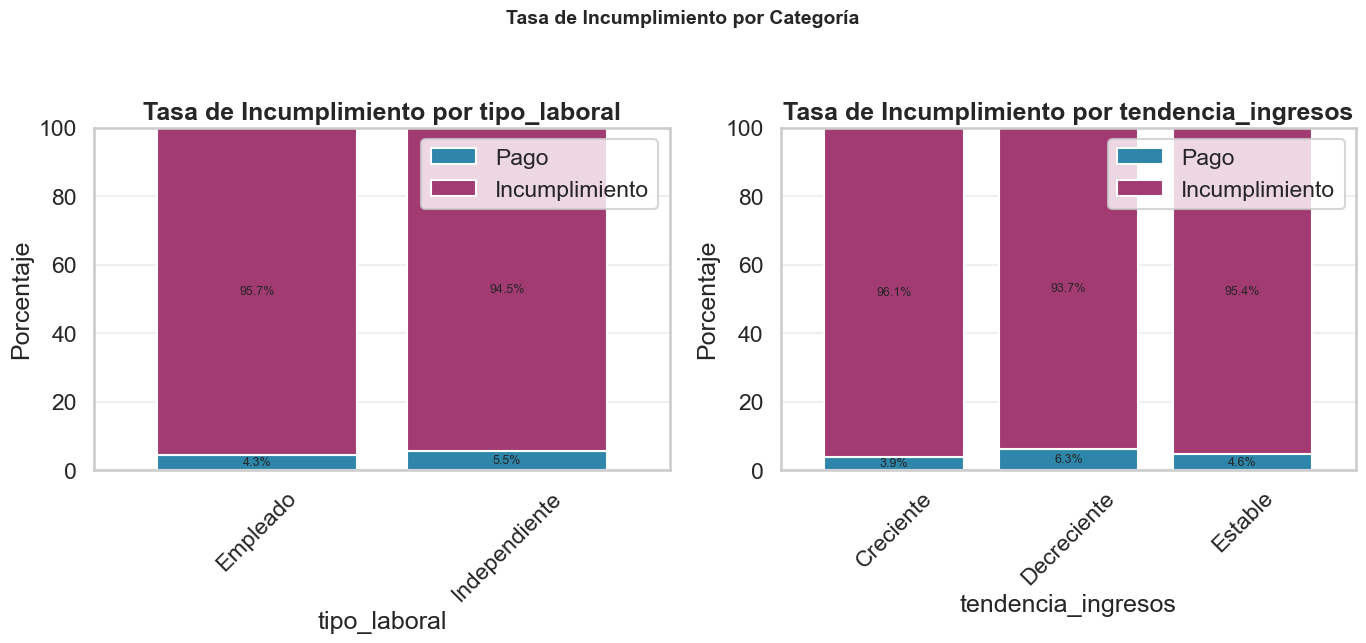

C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3261975192.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_by_cat = df.groupby(col)[target].mean().sort_values() * 100


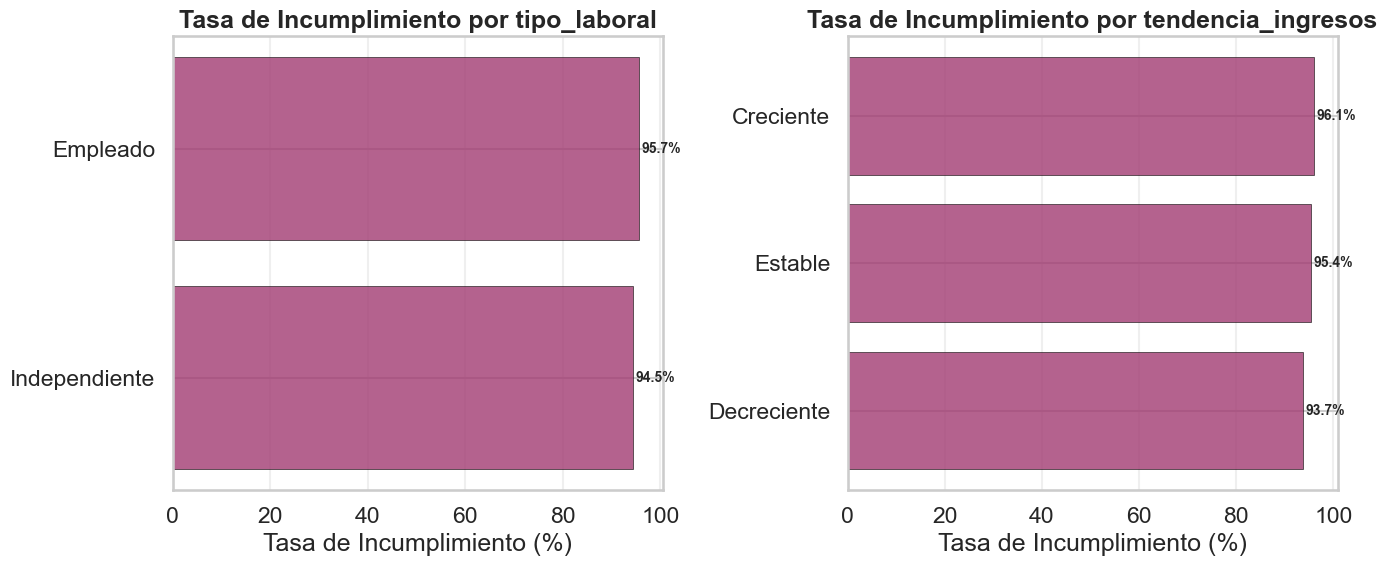

In [30]:
# ============================================
# 5. ANÁLISIS BIVARIADO VS VARIABLE OBJETIVO
# ============================================

print("\n" + "=" * 60)
print("5. ANÁLISIS BIVARIADO VS PAGO_ATIEMPO")
print("=" * 60)

if target is None:
    print("No se encontró variable objetivo. Verifique que exista en los datos.")
else:
    print(f"Variable objetivo: '{target}'")
    
    # 5.1 Tasa global de incumplimiento
    target_rate = df[target].mean()
    print(f"\nTASA GLOBAL DE INCUMPLIMIENTO: {target_rate:.2%}")
    print(f"Distribución: Pago a tiempo: {(1-target_rate):.2%}, Incumplimiento: {target_rate:.2%}")
    
    # Variables numéricas para análisis (excluyendo target)
    num_features = [c for c in num_cols if c != target]
    print(f"\nVariables numéricas a analizar: {num_features[:5]}...")
    
    # 5.2 Variables numéricas vs Pago_atiempo
    if len(num_features) > 0:
        # Boxplots comparativos
        n_plots = min(4, len(num_features))
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for i, col in enumerate(num_features[:n_plots]):
            ax = axes[i]
            sns.boxplot(x=target, y=col, data=df, palette=['#2E86AB', '#A23B72'], ax=ax)
            ax.set_title(f'{col} vs Pago_atiempo', fontweight='bold')
            ax.set_xlabel('Pago_atiempo (0 = Pago, 1 = Incumplimiento)')
            ax.set_ylabel(col)
            ax.grid(True, alpha=0.3)
            
            # Agregar estadísticos
            means = df.groupby(target)[col].mean().round(2)
            if len(means) == 2:
                ax.text(0.5, 0.95, f'Media 0: {means.iloc[0]}', transform=ax.transAxes, 
                    ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                ax.text(0.5, 0.88, f'Media 1: {means.iloc[1]}', transform=ax.transAxes, 
                    ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Ocultar subplots vacíos
        for i in range(n_plots, 4):
            axes[i].set_visible(False)
        
        plt.suptitle('Comparación de Variables Numéricas por Pago_atiempo', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Violin plots (distribución completa)
        if len(num_features) >= 2:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            for i, col in enumerate(num_features[:2]):
                sns.violinplot(x=target, y=col, data=df, palette=['#2E86AB', '#A23B72'], 
                            ax=axes[i], inner='quartile')
                axes[i].set_title(f'Distribución: {col} por Pago_atiempo', fontweight='bold')
                axes[i].set_xlabel('Pago_atiempo')
                axes[i].grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    # 5.3 Variables categóricas vs Pago_atiempo
    if len(cat_cols) > 0:
        n_plots = min(4, len(cat_cols))
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for i, col in enumerate(cat_cols[:n_plots]):
            ax = axes[i]
            # Tabla cruzada con porcentajes
            crosstab = pd.crosstab(df[col], df[target], normalize='index') * 100
            crosstab.columns = ['Pago %', 'Incumplimiento %']
            
            # Gráfico de barras apiladas
            crosstab.plot(kind='bar', stacked=True, ax=ax, color=['#2E86AB', '#A23B72'], width=0.8)
            ax.set_title(f'Tasa de Incumplimiento por {col}', fontweight='bold')
            ax.set_xlabel(col)
            ax.set_ylabel('Porcentaje')
            ax.legend(['Pago', 'Incumplimiento'], loc='upper right')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_ylim(0, 100)
            
            # Agregar etiquetas de porcentaje
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
        
        # Ocultar subplots vacíos
        for i in range(n_plots, 4):
            axes[i].set_visible(False)
        
        plt.suptitle('Tasa de Incumplimiento por Categoría', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Gráfico de barras horizontales para categorías de riesgo
        if len(cat_cols) >= 2:
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            for i, col in enumerate(cat_cols[:2]):
                ax = axes[i]
                target_by_cat = df.groupby(col)[target].mean().sort_values() * 100
                
                bars = ax.barh(target_by_cat.index, target_by_cat.values, 
                            color='#A23B72', alpha=0.8, edgecolor='black', linewidth=0.5)
                ax.set_title(f'Tasa de Incumplimiento por {col}', fontweight='bold')
                ax.set_xlabel('Tasa de Incumplimiento (%)')
                ax.grid(True, alpha=0.3, axis='x')
                
                # Agregar etiquetas
                for bar, val in zip(bars, target_by_cat.values):
                    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
                        va='center', fontweight='bold', fontsize=10)
            
            plt.tight_layout()
            plt.show()

### 6. Análisis Bivariado: Variables vs Pago_atiempo

**Objetivo:** Identificar qué variables tienen relación significativa con la variable objetivo.

Para cada variable:
1. Visualizaremos la relación con el target
2. Calcularemos tests estadísticos de significancia
3. Interpretaremos si es predictiva o no

**Tipos de análisis:**
- Variables **numéricas** vs target → t-test / Mann-Whitney U
- Variables **categóricas** vs target → Chi-cuadrado

In [ ]:
# ============================================
#   UNCIÓN: ANÁLISIS NUMÉRICA VS TARGET
# ============================================

from scipy.stats import ttest_ind, mannwhitneyu
#import matplotlib.pyplot as plt
#import seaborn as sns

def analizar_numerica_vs_target(df, variable, target='Pago_atiempo'):
    """
    Analiza relación entre variable numérica y target binario.
    Incluye visualización y test estadístico.
    """
    print("="*80)
    print(f" ANÁLISIS: {variable} vs {target}")
    print("="*80)
    
    # Separar por grupos
    grupo_0 = df[df[target] == 0][variable].dropna()
    grupo_1 = df[df[target] == 1][variable].dropna()
    
    # Estadísticas descriptivas
    print(f"\n Estadísticas Descriptivas:")
    print(f"   No pagó (0) - Media: {grupo_0.mean():,.2f} | Mediana: {grupo_0.median():,.2f} | Std: {grupo_0.std():,.2f}")
    print(f"   Sí pagó (1) - Media: {grupo_1.mean():,.2f} | Mediana: {grupo_1.median():,.2f} | Std: {grupo_1.std():,.2f}")
    print(f"   Diferencia de medias: {grupo_1.mean() - grupo_0.mean():,.2f}")
    
    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{variable} vs {target}', fontsize=14, fontweight='bold')
    
    # Boxplot comparativo
    df.boxplot(column=variable, by=target, ax=axes[0])
    axes[0].set_title('Boxplot Comparativo')
    axes[0].set_xlabel('Pago a Tiempo')
    axes[0].set_ylabel(variable)
    axes[0].set_xticklabels(['No (0)', 'Sí (1)'])
    plt.sca(axes[0])
    plt.xticks(rotation=0)
    
    # Violin plot
    sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
    axes[1].set_title('Violin Plot')
    axes[1].set_xlabel('Pago a Tiempo')
    axes[1].set_xticklabels(['No (0)', 'Sí (1)'])
    
    # Histogramas superpuestos
    axes[2].hist(grupo_0, bins=30, alpha=0.6, label='No pagó (0)', color='#e74c3c', edgecolor='black')
    axes[2].hist(grupo_1, bins=30, alpha=0.6, label='Sí pagó (1)', color='#2ecc71', edgecolor='black')
    axes[2].set_title('Distribuciones Superpuestas')
    axes[2].set_xlabel(variable)
    axes[2].set_ylabel('Frecuencia')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Test estadístico
    print(f"\n Test Estadístico:")
    
    # T-test (paramétrico)
    stat_t, pvalue_t = ttest_ind(grupo_0, grupo_1)
    print(f"   T-test:")
    print(f"     Statistic: {stat_t:.4f}")
    print(f"     P-value: {pvalue_t:.6f}")
    
    # Mann-Whitney U (no paramétrico - más robusto)
    stat_u, pvalue_u = mannwhitneyu(grupo_0, grupo_1, alternative='two-sided')
    print(f"\n   Mann-Whitney U (no paramétrico):")
    print(f"     Statistic: {stat_u:.4f}")
    print(f"     P-value: {pvalue_u:.6f}")
    
    # Interpretación
    print(f"\n INTERPRETACIÓN:")
    if pvalue_u < 0.001:
        print(f"   ✓✓✓ Diferencia ALTAMENTE SIGNIFICATIVA (p < 0.001)")
        print(f"   → {variable} es MUY PREDICTIVA del target")
        significancia = "ALTA"
    elif pvalue_u < 0.01:
        print(f"   ✓✓ Diferencia MUY SIGNIFICATIVA (p < 0.01)")
        print(f"   → {variable} es PREDICTIVA del target")
        significancia = "MEDIA-ALTA"
    elif pvalue_u < 0.05:
        print(f"   ✓ Diferencia SIGNIFICATIVA (p < 0.05)")
        print(f"   → {variable} es MODERADAMENTE PREDICTIVA")
        significancia = "MEDIA"
    else:
        print(f"   ✗ NO hay diferencia significativa (p >= 0.05)")
        print(f"   → {variable} NO es predictiva del target")
        significancia = "BAJA"
    
    print("="*80)
    
    return {
        'variable': variable,
        'pvalue': pvalue_u,
        'significancia': significancia,
        'diferencia_medias': grupo_1.mean() - grupo_0.mean()
    }

print(" Función analizar_numerica_vs_target() creada")


✓ Función analizar_numerica_vs_target() creada


 ANÁLISIS: capital_prestado vs Pago_atiempo

 Estadísticas Descriptivas:
   No pagó (0) - Media: 2,781,774.11 | Mediana: 2,268,000.00 | Std: 1,942,337.70
   Sí pagó (1) - Media: 2,416,996.27 | Mediana: 1,908,446.40 | Std: 1,906,438.41
   Diferencia de medias: -364,777.84


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['No (0)', 'Sí (1)'])


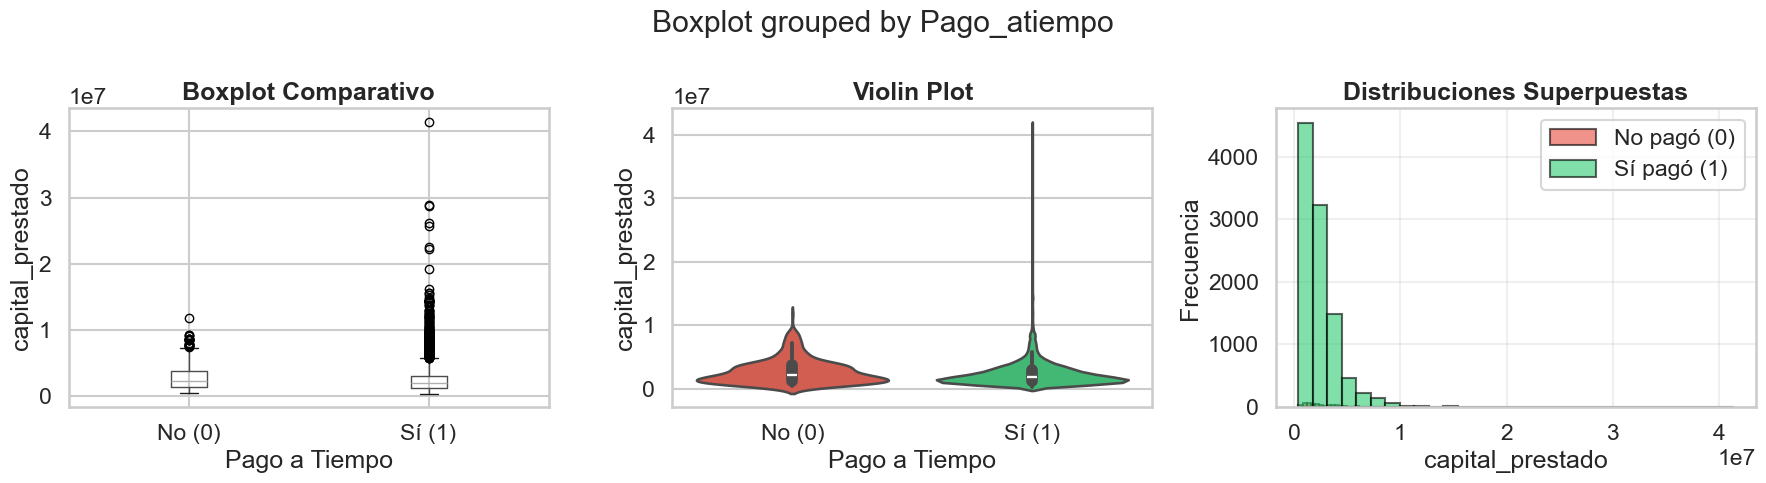


🔬 Test Estadístico:
   T-test:
     Statistic: 4.2176
     P-value: 0.000025

   Mann-Whitney U (no paramétrico):
     Statistic: 2917963.0000
     P-value: 0.000013

 INTERPRETACIÓN:
   ✓✓✓ Diferencia ALTAMENTE SIGNIFICATIVA (p < 0.001)
   → capital_prestado es MUY PREDICTIVA del target

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: puntaje vs Pago_atiempo

 Estadísticas Descriptivas:
   No pagó (0) - Media: 23.09 | Mediana: 25.42 | Std: 26.07
   Sí pagó (1) - Media: 94.56 | Mediana: 95.23 | Std: 2.87
   Diferencia de medias: 71.47


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['No (0)', 'Sí (1)'])


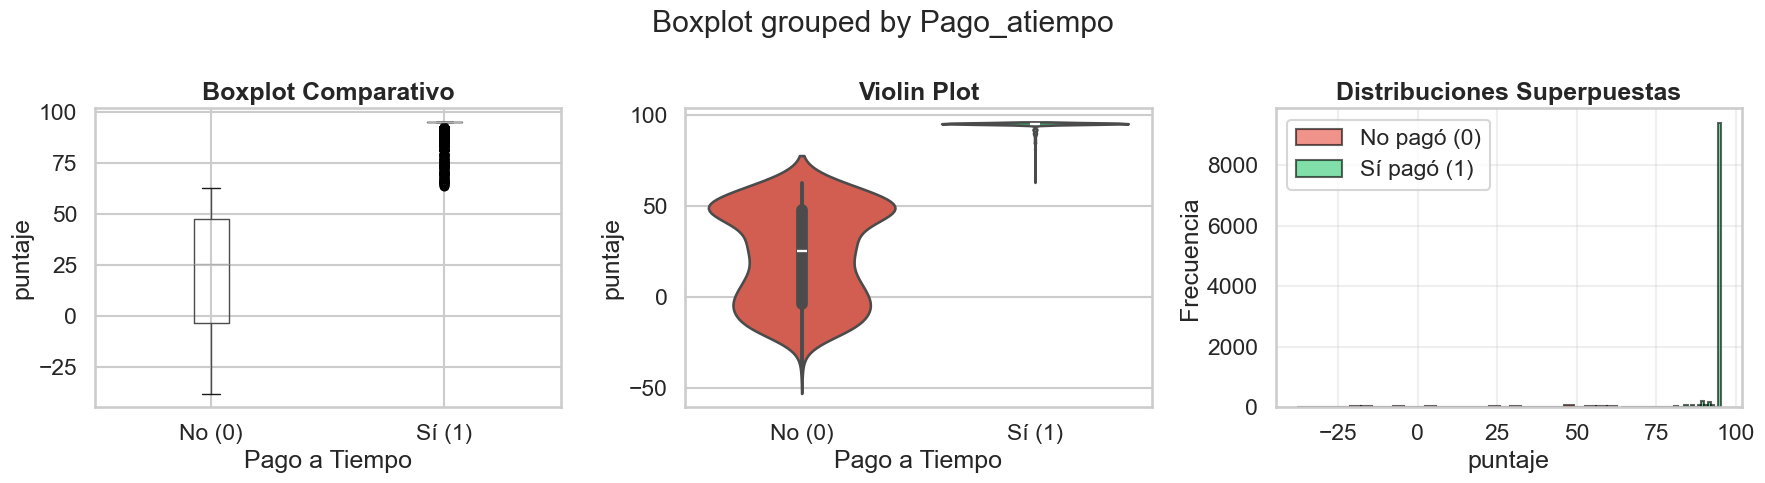


🔬 Test Estadístico:
   T-test:
     Statistic: -249.0696
     P-value: 0.000000

   Mann-Whitney U (no paramétrico):
     Statistic: 0.0000
     P-value: 0.000000

 INTERPRETACIÓN:
   ✓✓✓ Diferencia ALTAMENTE SIGNIFICATIVA (p < 0.001)
   → puntaje es MUY PREDICTIVA del target

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: puntaje_datacredito vs Pago_atiempo

 Estadísticas Descriptivas:
   No pagó (0) - Media: 748.88 | Mediana: 768.00 | Std: 130.91
   Sí pagó (1) - Media: 782.38 | Mediana: 792.00 | Std: 103.16
   Diferencia de medias: 33.50


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['No (0)', 'Sí (1)'])


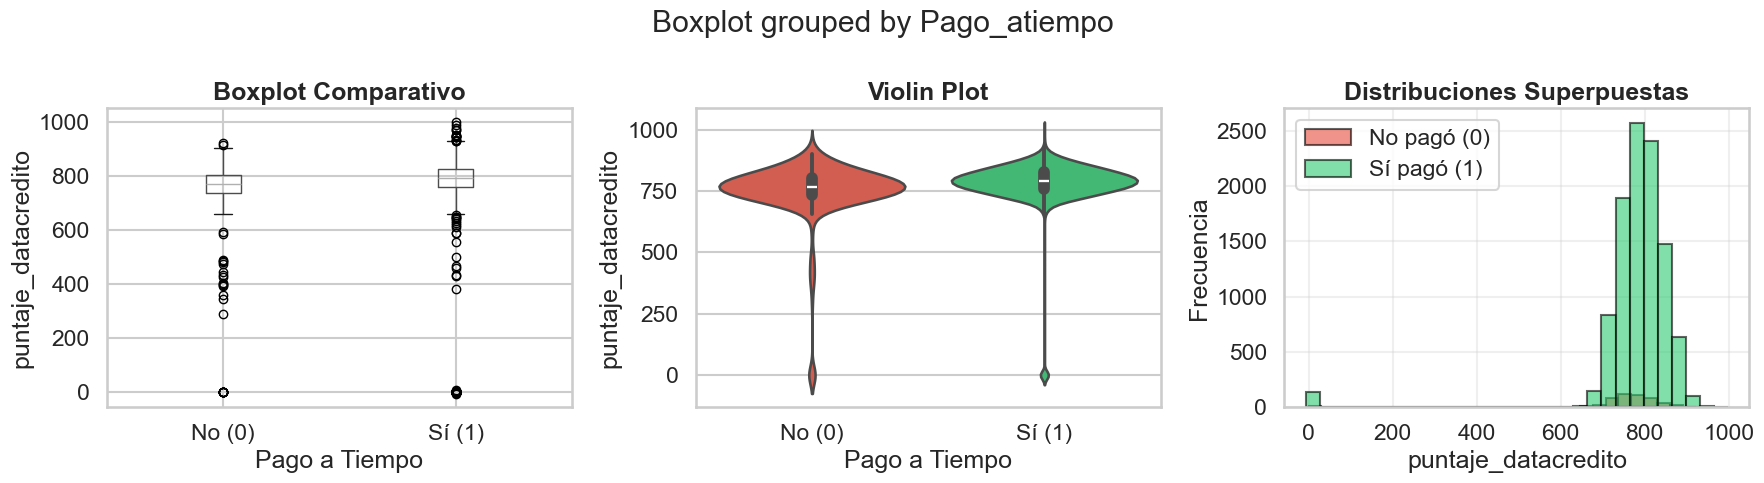


🔬 Test Estadístico:
   T-test:
     Statistic: -7.0561
     P-value: 0.000000

   Mann-Whitney U (no paramétrico):
     Statistic: 1969716.5000
     P-value: 0.000000

 INTERPRETACIÓN:
   ✓✓✓ Diferencia ALTAMENTE SIGNIFICATIVA (p < 0.001)
   → puntaje_datacredito es MUY PREDICTIVA del target

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: edad_cliente vs Pago_atiempo

 Estadísticas Descriptivas:
   No pagó (0) - Media: 41.77 | Mediana: 38.00 | Std: 17.06
   Sí pagó (1) - Media: 44.06 | Mediana: 42.00 | Std: 14.95
   Diferencia de medias: 2.28


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['No (0)', 'Sí (1)'])


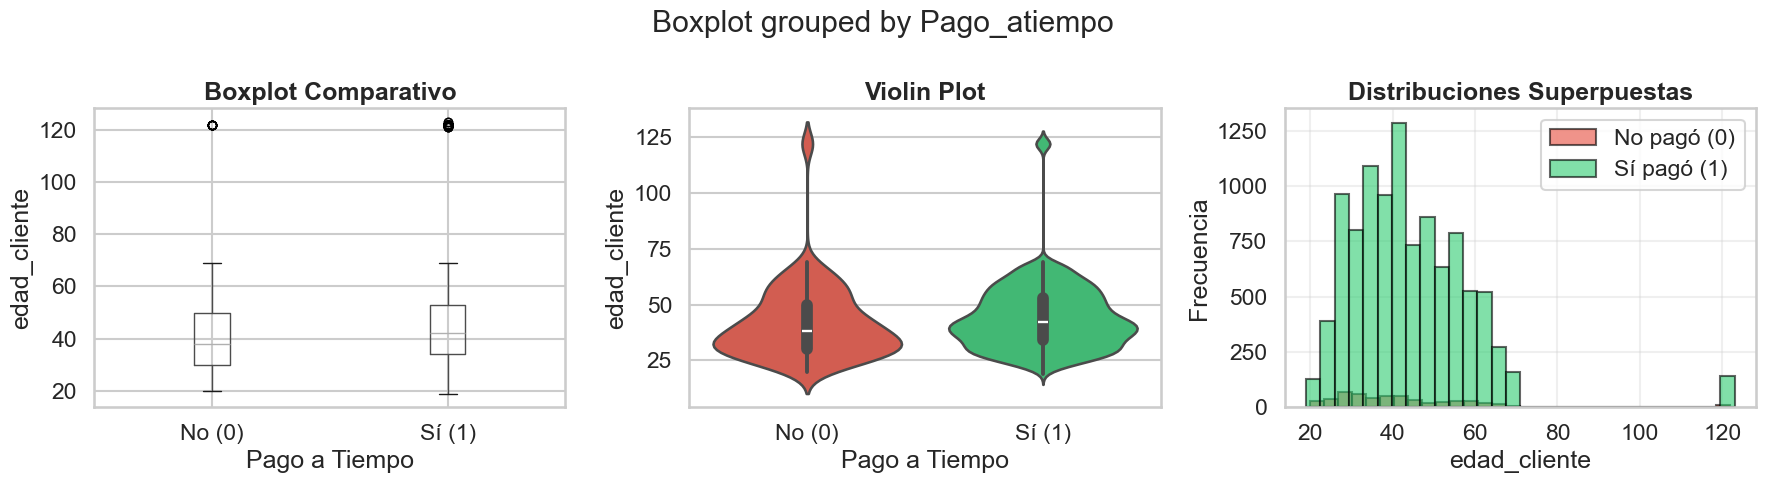


🔬 Test Estadístico:
   T-test:
     Statistic: -3.3474
     P-value: 0.000818

   Mann-Whitney U (no paramétrico):
     Statistic: 2257181.5000
     P-value: 0.000000

 INTERPRETACIÓN:
   ✓✓✓ Diferencia ALTAMENTE SIGNIFICATIVA (p < 0.001)
   → edad_cliente es MUY PREDICTIVA del target

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: salario_cliente vs Pago_atiempo

 Estadísticas Descriptivas:
   No pagó (0) - Media: 23,555,143.33 | Mediana: 3,000,000.00 | Std: 274,787,635.68
   Sí pagó (1) - Media: 16,900,485.13 | Mediana: 3,000,000.00 | Std: 359,032,091.87
   Diferencia de medias: -6,654,658.20


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['No (0)', 'Sí (1)'])


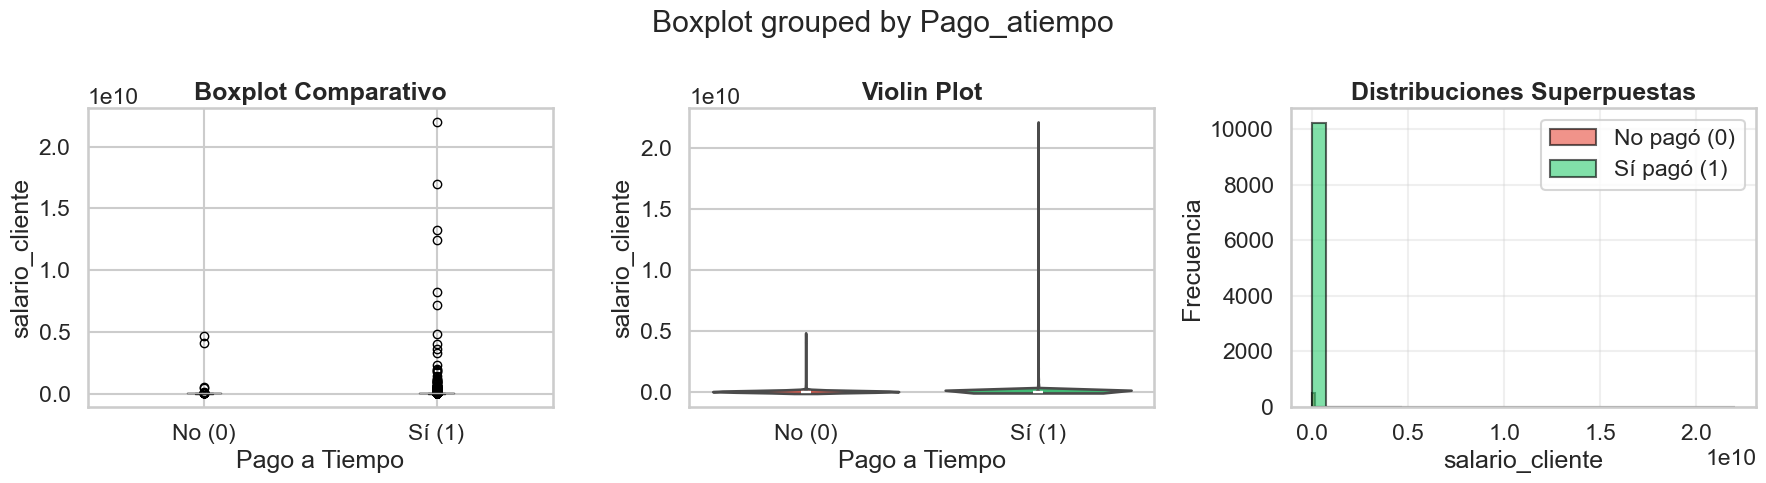


🔬 Test Estadístico:
   T-test:
     Statistic: 0.4130
     P-value: 0.679618

   Mann-Whitney U (no paramétrico):
     Statistic: 2652922.5000
     P-value: 0.624382

 INTERPRETACIÓN:
   ✗ NO hay diferencia significativa (p >= 0.05)
   → salario_cliente NO es predictiva del target

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: cant_creditosvigentes vs Pago_atiempo

 Estadísticas Descriptivas:
   No pagó (0) - Media: 5.57 | Mediana: 5.00 | Std: 4.14
   Sí pagó (1) - Media: 5.73 | Mediana: 5.00 | Std: 3.97
   Diferencia de medias: 0.17


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['No (0)', 'Sí (1)'])


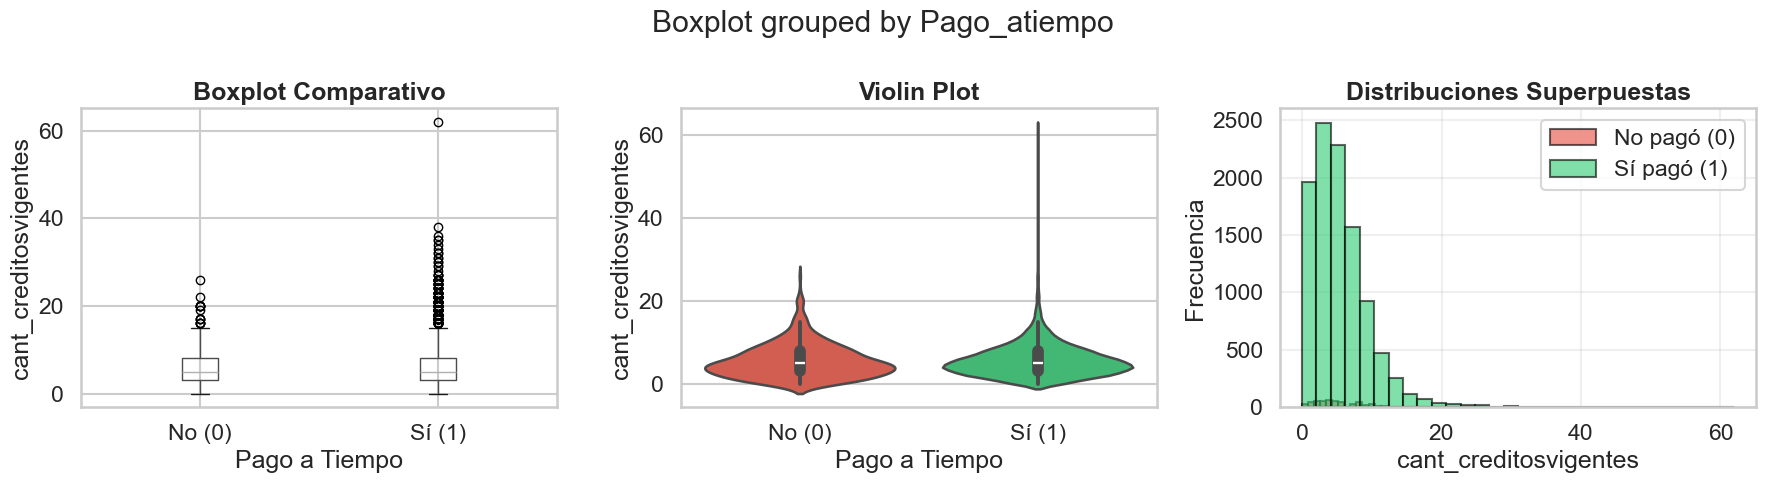


🔬 Test Estadístico:
   T-test:
     Statistic: -0.9159
     P-value: 0.359724

   Mann-Whitney U (no paramétrico):
     Statistic: 2507955.5000
     P-value: 0.102560

 INTERPRETACIÓN:
   ✗ NO hay diferencia significativa (p >= 0.05)
   → cant_creditosvigentes NO es predictiva del target

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: huella_consulta vs Pago_atiempo

 Estadísticas Descriptivas:
   No pagó (0) - Media: 5.24 | Mediana: 5.00 | Std: 3.45
   Sí pagó (1) - Media: 4.18 | Mediana: 4.00 | Std: 3.04
   Diferencia de medias: -1.06


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['No (0)', 'Sí (1)'])


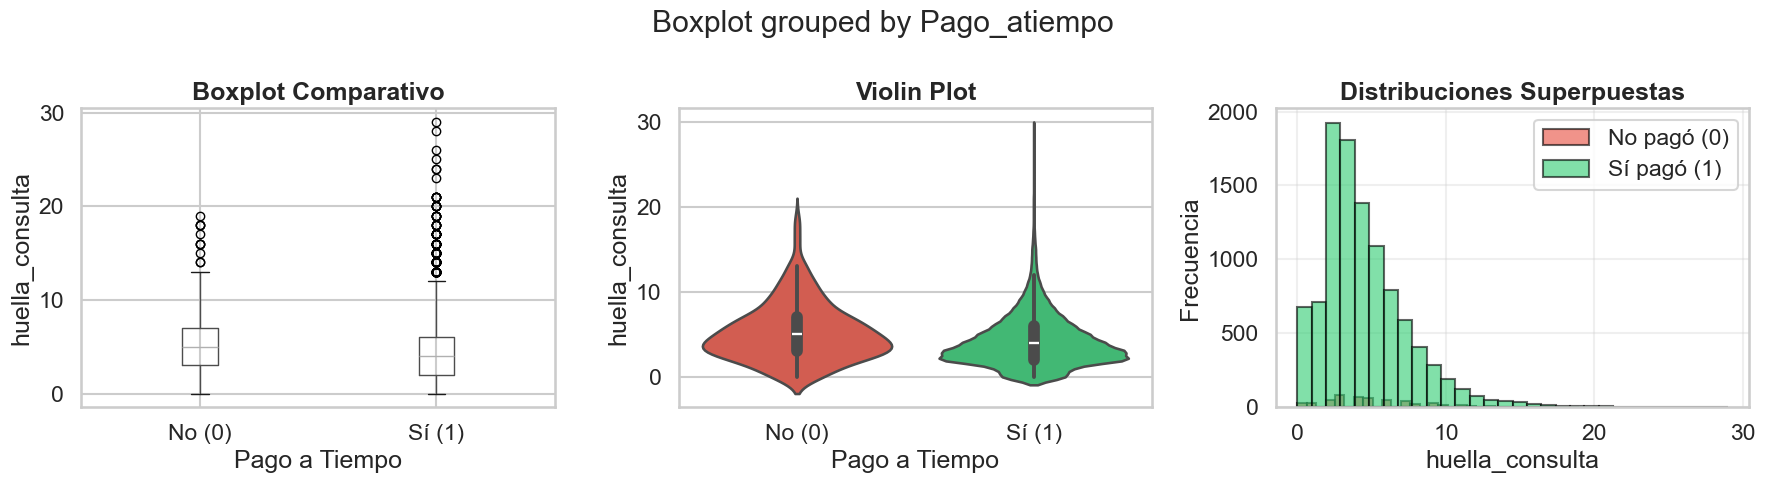


🔬 Test Estadístico:
   T-test:
     Statistic: 7.6700
     P-value: 0.000000

   Mann-Whitney U (no paramétrico):
     Statistic: 3133577.5000
     P-value: 0.000000

 INTERPRETACIÓN:
   ✓✓✓ Diferencia ALTAMENTE SIGNIFICATIVA (p < 0.001)
   → huella_consulta es MUY PREDICTIVA del target

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: total_otros_prestamos vs Pago_atiempo

 Estadísticas Descriptivas:
   No pagó (0) - Media: 11,564,401.93 | Mediana: 900,000.00 | Std: 178,148,935.52
   Sí pagó (1) - Media: 5,973,424.18 | Mediana: 1,000,000.00 | Std: 114,636,297.61
   Diferencia de medias: -5,590,977.75


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['No (0)', 'Sí (1)'])


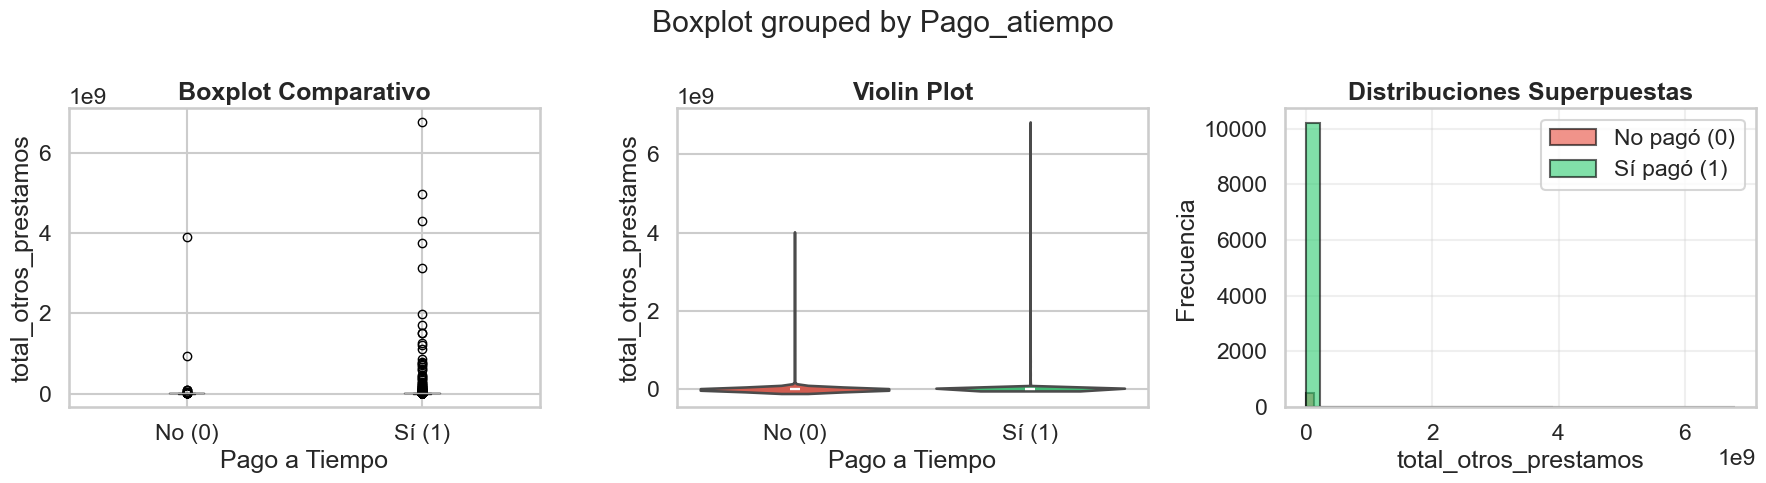


🔬 Test Estadístico:
   T-test:
     Statistic: 1.0416
     P-value: 0.297601

   Mann-Whitney U (no paramétrico):
     Statistic: 2433957.0000
     P-value: 0.006763

 INTERPRETACIÓN:
   ✓✓ Diferencia MUY SIGNIFICATIVA (p < 0.01)
   → total_otros_prestamos es PREDICTIVA del target

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: plazo_meses vs Pago_atiempo

 Estadísticas Descriptivas:
   No pagó (0) - Media: 12.45 | Mediana: 10.00 | Std: 9.27
   Sí pagó (1) - Media: 10.48 | Mediana: 10.00 | Std: 6.46
   Diferencia de medias: -1.97


C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target, y=variable, ax=axes[1], palette=['#e74c3c', '#2ecc71'])
C:\Users\USER\AppData\Local\Temp\ipykernel_2720\3441822941.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['No (0)', 'Sí (1)'])


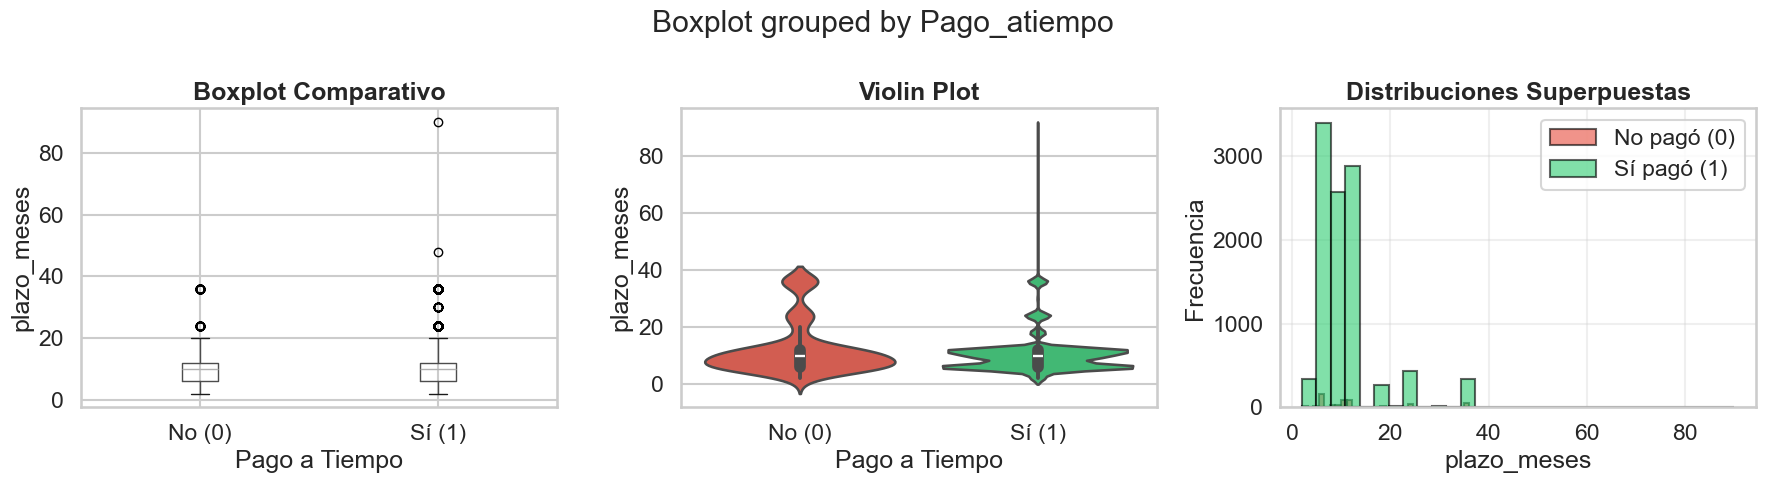


🔬 Test Estadístico:
   T-test:
     Statistic: 6.5593
     P-value: 0.000000

   Mann-Whitney U (no paramétrico):
     Statistic: 2729588.0000
     P-value: 0.099446

 INTERPRETACIÓN:
   ✗ NO hay diferencia significativa (p >= 0.05)
   → plazo_meses NO es predictiva del target

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*


 RESUMEN: VARIABLES NUMÉRICAS VS TARGET
             variable       pvalue significancia  diferencia_medias
              puntaje 0.000000e+00          ALTA       7.147214e+01
  puntaje_datacredito 5.553474e-21          ALTA       3.349865e+01
      huella_consulta 3.907248e-14          ALTA      -1.062593e+00
         edad_cliente 1.255361e-07          ALTA       2.284068e+00
     capital_prestado 1.327169e-05          ALTA      -3.647778e+05
total_otros_prestamos 6.762576e-03    MEDIA-ALTA      -5.590978e+06
          plazo_meses 9.944585e-02          BAJA      -1.967948e+00
cant_creditosvigentes 1.025599e-01          BAJA       1.651167e-01
     

In [37]:
# ============================================
#    ANÁLISIS DE VARIABLES NUMÉRICAS CLAVE
# ============================================

# Variables numéricas más relevantes para analizar
variables_numericas = [
    'capital_prestado',
    'puntaje',
    'puntaje_datacredito',
    'edad_cliente',
    'salario_cliente',
    'cant_creditosvigentes',
    'huella_consulta',
    'total_otros_prestamos',
    'plazo_meses'
]

# Analizar cada variable
resultados_numericas = []

for var in variables_numericas:
    if var in df.columns:
        resultado = analizar_numerica_vs_target(df, var)
        resultados_numericas.append(resultado)
        print("\n" + "➖*"*30 + "\n")
    else:
        print(f" Variable {var} no encontrada en el dataset")

# Crear resumen
print("\n" + "="*80)
print(" RESUMEN: VARIABLES NUMÉRICAS VS TARGET")
print("="*80)

df_resumen_num = pd.DataFrame(resultados_numericas)
df_resumen_num = df_resumen_num.sort_values('pvalue')

print(df_resumen_num.to_string(index=False))

print("\n VARIABLES MÁS PREDICTIVAS (p < 0.05):")
predictivas = df_resumen_num[df_resumen_num['pvalue'] < 0.05]
if len(predictivas) > 0:
    for idx, row in predictivas.iterrows():
        print(f"   ✓ {row['variable']:30} (p={row['pvalue']:.6f}, sig={row['significancia']})")
else:
    print("    Ninguna variable mostró significancia estadística")

print("="*80)


In [38]:
# ============================================
#   FUNCIÓN: ANÁLISIS CATEGÓRICA VS TARGET
# ============================================

from scipy.stats import chi2_contingency

def analizar_categorica_vs_target(df, variable, target='Pago_atiempo'):
    """
    Analiza relación entre variable categórica y target binario.
    Incluye visualización y test Chi-cuadrado.
    """
    print("="*80)
    print(f" ANÁLISIS: {variable} vs {target}")
    print("="*80)
    
    # Tabla cruzada (frecuencias)
    crosstab_freq = pd.crosstab(df[variable], df[target])
    print(f"\n Tabla de Frecuencias:")
    print(crosstab_freq)
    
    # Tabla cruzada (porcentajes por fila)
    crosstab_pct = pd.crosstab(df[variable], df[target], normalize='index') * 100
    print(f"\n Porcentajes por Fila (%):")
    print(crosstab_pct.round(2))
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{variable} vs {target}', fontsize=14, fontweight='bold')
    
    # Gráfico de barras agrupadas
    crosstab_pct.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'], 
                    edgecolor='black', alpha=0.8)
    axes[0].set_title('Tasa de Pago por Categoría')
    axes[0].set_xlabel(variable)
    axes[0].set_ylabel('Porcentaje (%)')
    axes[0].legend(['No pagó (0)', 'Pagó (1)'], loc='best')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Heatmap
    sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='RdYlGn', 
                ax=axes[1], cbar_kws={'label': 'Porcentaje (%)'})
    axes[1].set_title('Heatmap de Proporciones')
    axes[1].set_xlabel('Pago a Tiempo')
    axes[1].set_ylabel(variable)
    
    plt.tight_layout()
    plt.show()
    
    # Test Chi-cuadrado
    print(f"\n🔬 Test Estadístico (Chi-cuadrado):")
    chi2, pvalue, dof, expected = chi2_contingency(crosstab_freq)
    
    print(f"   Chi-cuadrado: {chi2:.4f}")
    print(f"   P-value: {pvalue:.6f}")
    print(f"   Grados de libertad: {dof}")
    
    # Interpretación
    print(f"\n INTERPRETACIÓN:")
    if pvalue < 0.001:
        print(f"   ✓✓✓ Asociación ALTAMENTE SIGNIFICATIVA (p < 0.001)")
        print(f"   → {variable} está FUERTEMENTE asociada con el target")
        significancia = "ALTA"
    elif pvalue < 0.01:
        print(f"   ✓✓ Asociación MUY SIGNIFICATIVA (p < 0.01)")
        print(f"   → {variable} está asociada con el target")
        significancia = "MEDIA-ALTA"
    elif pvalue < 0.05:
        print(f"   ✓ Asociación SIGNIFICATIVA (p < 0.05)")
        print(f"   → {variable} tiene relación moderada con el target")
        significancia = "MEDIA"
    else:
        print(f"   ✗ NO hay asociación significativa (p >= 0.05)")
        print(f"   → {variable} NO está asociada con el target")
        significancia = "BAJA"
    
    # Análisis de categorías
    print(f"\n Análisis por Categoría:")
    for cat in crosstab_pct.index:
        tasa_pago = crosstab_pct.loc[cat, 1]
        print(f"   {cat}: {tasa_pago:.2f}% paga a tiempo")
    
    print("="*80)
    
    return {
        'variable': variable,
        'pvalue': pvalue,
        'chi2': chi2,
        'significancia': significancia
    }

print(" Función analizar_categorica_vs_target() creada")

 Función analizar_categorica_vs_target() creada


 ANÁLISIS: tipo_laboral vs Pago_atiempo

 Tabla de Frecuencias:
Pago_atiempo     0     1
tipo_laboral            
Empleado       290  6464
Independiente  221  3788

 Porcentajes por Fila (%):
Pago_atiempo      0      1
tipo_laboral              
Empleado       4.29  95.71
Independiente  5.51  94.49


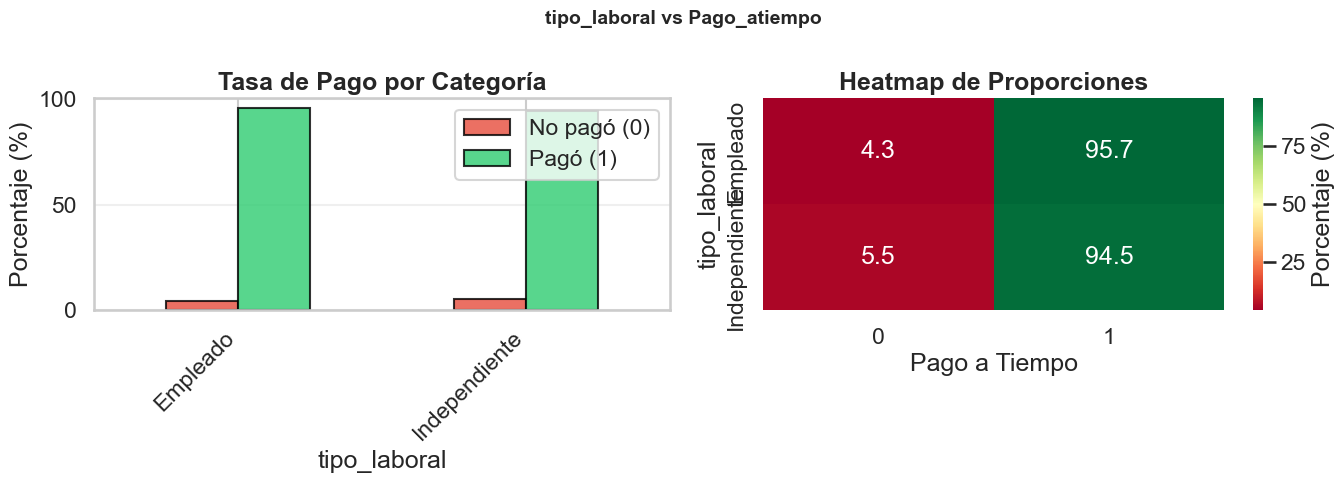


🔬 Test Estadístico (Chi-cuadrado):
   Chi-cuadrado: 7.9968
   P-value: 0.004686
   Grados de libertad: 1

 INTERPRETACIÓN:
   ✓✓ Asociación MUY SIGNIFICATIVA (p < 0.01)
   → tipo_laboral está asociada con el target

 Análisis por Categoría:
   Empleado: 95.71% paga a tiempo
   Independiente: 94.49% paga a tiempo

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: tendencia_ingresos vs Pago_atiempo

 Tabla de Frecuencias:
Pago_atiempo          0     1
tendencia_ingresos           
Creciente           207  5087
Decreciente          81  1210
Estable              55  1133

 Porcentajes por Fila (%):
Pago_atiempo           0      1
tendencia_ingresos             
Creciente           3.91  96.09
Decreciente         6.27  93.73
Estable             4.63  95.37


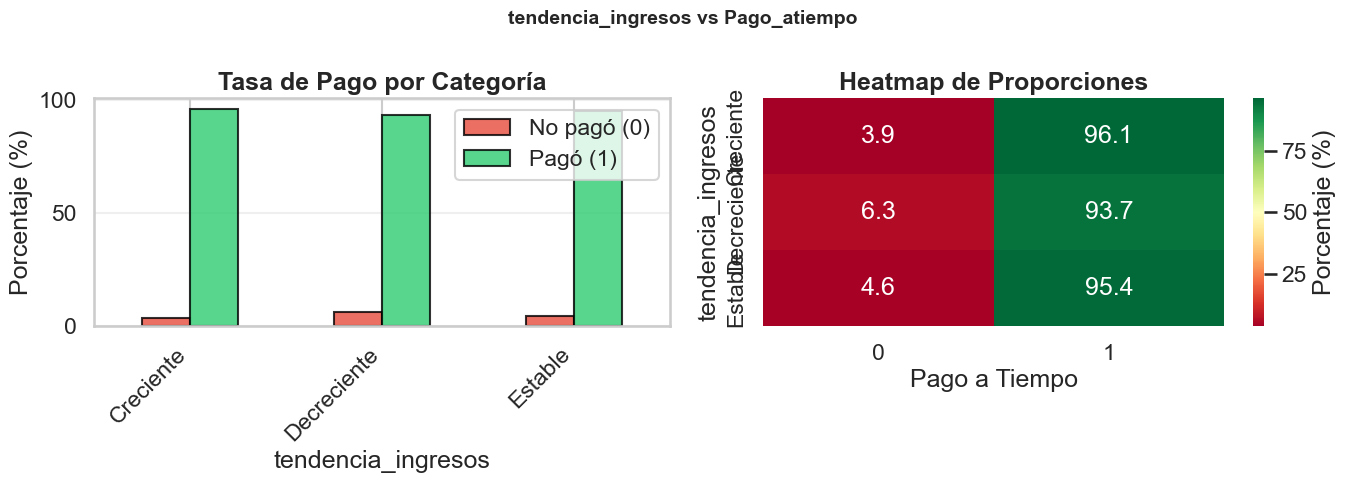


🔬 Test Estadístico (Chi-cuadrado):
   Chi-cuadrado: 13.9091
   P-value: 0.000954
   Grados de libertad: 2

 INTERPRETACIÓN:
   ✓✓✓ Asociación ALTAMENTE SIGNIFICATIVA (p < 0.001)
   → tendencia_ingresos está FUERTEMENTE asociada con el target

 Análisis por Categoría:
   Creciente: 96.09% paga a tiempo
   Decreciente: 93.73% paga a tiempo
   Estable: 95.37% paga a tiempo

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*

 ANÁLISIS: tipo_credito vs Pago_atiempo

 Tabla de Frecuencias:
Pago_atiempo    0     1
tipo_credito           
4             363  7384
6               9    12
7               0     2
9             136  2740
10              3   113
68              0     1

 Porcentajes por Fila (%):
Pago_atiempo      0       1
tipo_credito               
4              4.69   95.31
6             42.86   57.14
7              0.00  100.00
9              4.73   95.27
10             2.59   97.41
68             0.00  100.00


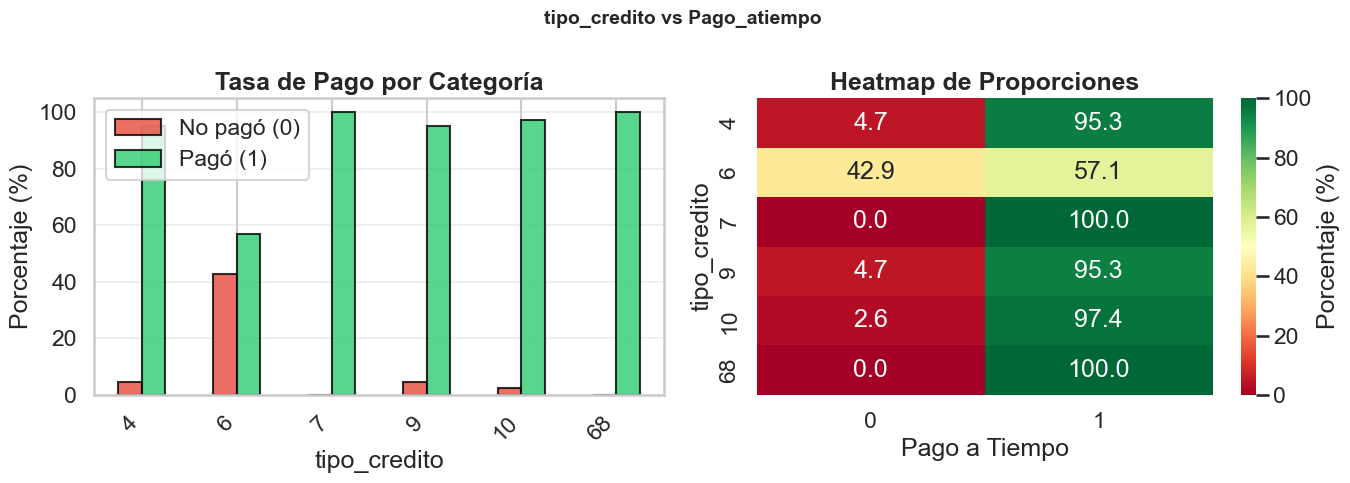


🔬 Test Estadístico (Chi-cuadrado):
   Chi-cuadrado: 68.8567
   P-value: 0.000000
   Grados de libertad: 5

 INTERPRETACIÓN:
   ✓✓✓ Asociación ALTAMENTE SIGNIFICATIVA (p < 0.001)
   → tipo_credito está FUERTEMENTE asociada con el target

 Análisis por Categoría:
   4: 95.31% paga a tiempo
   6: 57.14% paga a tiempo
   7: 100.00% paga a tiempo
   9: 95.27% paga a tiempo
   10: 97.41% paga a tiempo
   68: 100.00% paga a tiempo

➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*➖*


 RESUMEN: VARIABLES CATEGÓRICAS VS TARGET
          variable       pvalue      chi2 significancia
      tipo_credito 1.772029e-13 68.856727          ALTA
tendencia_ingresos 9.542725e-04 13.909123          ALTA
      tipo_laboral 4.685950e-03  7.996823    MEDIA-ALTA

 VARIABLES CON ASOCIACIÓN SIGNIFICATIVA (p < 0.05):
   ✓ tipo_credito                   (p=0.000000, sig=ALTA)
   ✓ tendencia_ingresos             (p=0.000954, sig=ALTA)
   ✓ tipo_laboral                   (p=0.004686, sig=MEDIA-ALTA)


In [39]:
# ============================================
#     ANÁLISIS DE VARIABLES CATEGÓRICAS
# ============================================

# Variables categóricas para analizar
variables_categoricas = [
    'tipo_laboral',
    'tendencia_ingresos',
    'tipo_credito'
]

# Analizar cada variable
resultados_categoricas = []

for var in variables_categoricas:
    if var in df.columns:
        resultado = analizar_categorica_vs_target(df, var)
        resultados_categoricas.append(resultado)
        print("\n" + "➖*"*30 + "\n")
    else:
        print(f" Variable {var} no encontrada en el dataset")

# Crear resumen
print("\n" + "="*80)
print(" RESUMEN: VARIABLES CATEGÓRICAS VS TARGET")
print("="*80)

df_resumen_cat = pd.DataFrame(resultados_categoricas)
df_resumen_cat = df_resumen_cat.sort_values('pvalue')

print(df_resumen_cat.to_string(index=False))

print("\n VARIABLES CON ASOCIACIÓN SIGNIFICATIVA (p < 0.05):")
asociadas = df_resumen_cat[df_resumen_cat['pvalue'] < 0.05]
if len(asociadas) > 0:
    for idx, row in asociadas.iterrows():
        print(f"   ✓ {row['variable']:30} (p={row['pvalue']:.6f}, sig={row['significancia']})")
else:
    print("    Ninguna variable mostró asociación significativa")

print("="*80)

## 6. Análisis Multivariado

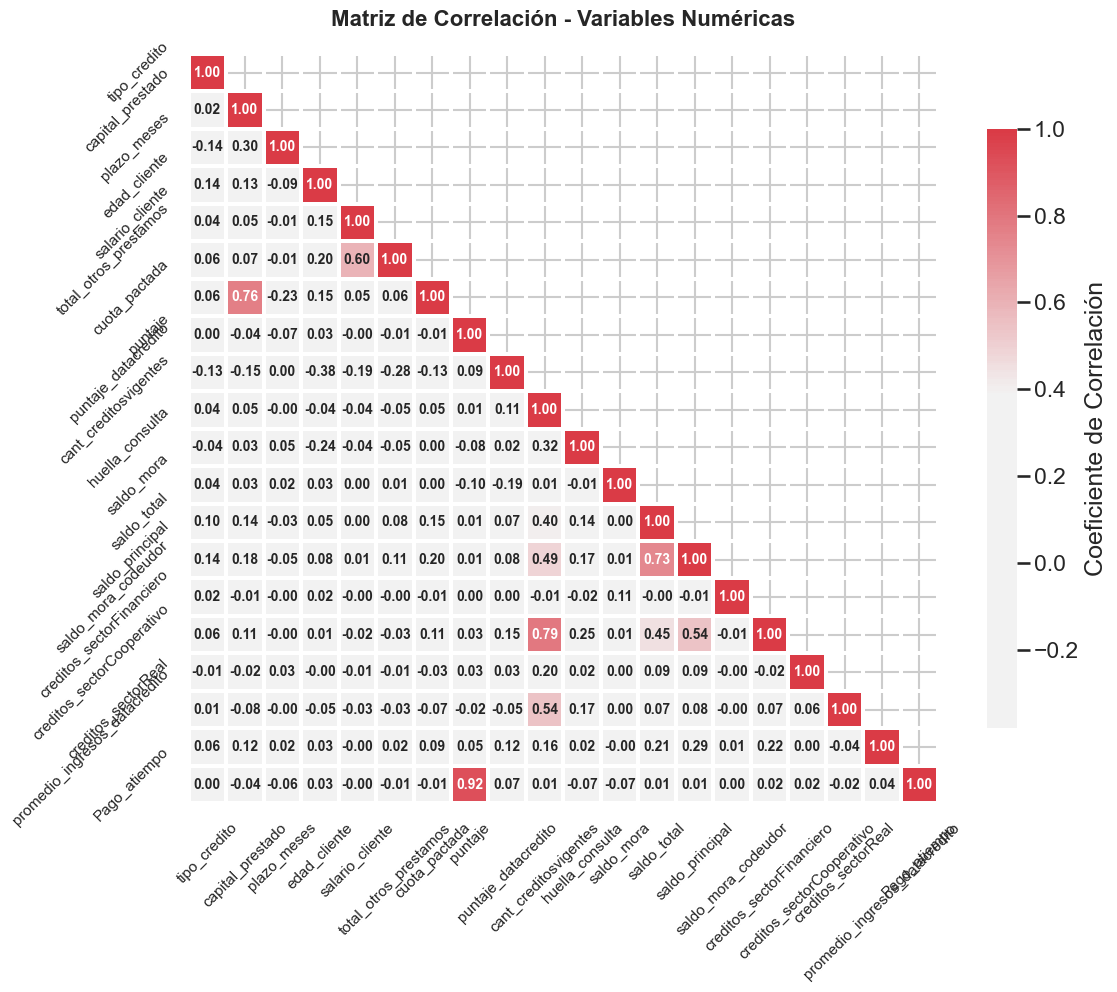

TOP 10 CORRELACIONES MÁS FUERTES:
  puntaje - Pago_atiempo: 0.923
  Pago_atiempo - puntaje: 0.923
  cant_creditosvigentes - creditos_sectorFinanciero: 0.791
  creditos_sectorFinanciero - cant_creditosvigentes: 0.791
  capital_prestado - cuota_pactada: 0.764
  cuota_pactada - capital_prestado: 0.764
  saldo_principal - saldo_total: 0.735
  saldo_total - saldo_principal: 0.735
  total_otros_prestamos - salario_cliente: 0.597
  salario_cliente - total_otros_prestamos: 0.597


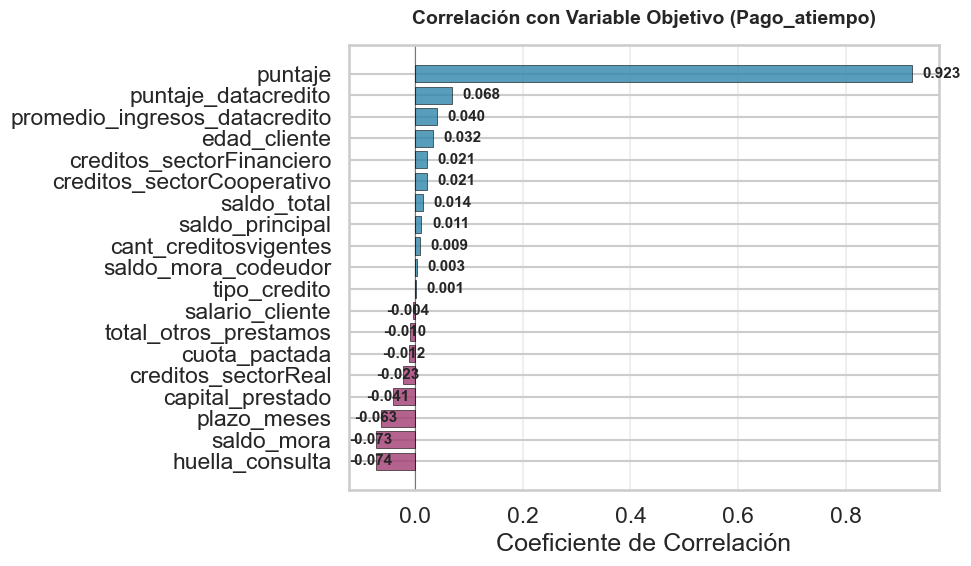

In [40]:
# 6.1 Matriz de correlación para variables numéricas
if len(num_cols) >= 2:
    
    # Preparar datos para correlación
    corr_data = df[num_cols].copy()
    corr_matrix = corr_data.corr()
    
    # Configurar figura
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Máscara para triangular superior
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    
    # Colormap personalizado
    cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
    
    # Heatmap
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                fmt='.2f', 
                cmap=cmap,
                center=0,
                square=True,
                linewidths=1.5,
                linecolor='white',
                cbar_kws={"shrink": 0.8, "label": "Coeficiente de Correlación"},
                annot_kws={"size": 10, "weight": "bold"},
                ax=ax)
    
    ax.set_title('Matriz de Correlación - Variables Numéricas', 
                fontsize=16, fontweight='bold', pad=20)
    ax.tick_params(axis='both', which='major', labelsize=11, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 6.2 Correlaciones más fuertes (top 10)
    corr_unstacked = corr_matrix.unstack()
    corr_unstacked = corr_unstacked[corr_unstacked < 1]  # Eliminar diagonales
    top_corr = corr_unstacked.abs().sort_values(ascending=False).head(10)
    
    print("TOP 10 CORRELACIONES MÁS FUERTES:")
    for idx, val in top_corr.items():
        print(f"  {idx[0]} - {idx[1]}: {corr_matrix.loc[idx[0], idx[1]]:.3f}")

# 6.3 Correlación con variable objetivo (si existe)
if target and target in num_cols:
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Correlaciones con target (excluyendo target mismo)
    corr_target = corr_matrix[target].drop(target).sort_values()
    
    # Colores según signo
    colors = ['#A23B72' if x < 0 else '#2E86AB' for x in corr_target.values]
    
    bars = ax.barh(corr_target.index, corr_target.values, color=colors, 
                edgecolor='black', linewidth=0.5, alpha=0.8)
    
    ax.set_title(f'Correlación con Variable Objetivo ({target})', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Coeficiente de Correlación')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Agregar valores
    for bar, val in zip(bars, corr_target.values):
        ax.text(val + (0.02 if val >= 0 else -0.05), 
            bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.show()

###  Análisis Multivariado

**Objetivo:** Identificar relaciones entre variables y detectar multicolinealidad.

Analizaremos:
1. **Matriz de correlación** entre variables numéricas
2. **Multicolinealidad** (variables muy correlacionadas)
3. **Pairplot** de variables clave
4. **Relaciones complejas** entre predictores

 ANÁLISIS DE CORRELACIONES

Variables numéricas para análisis: 19


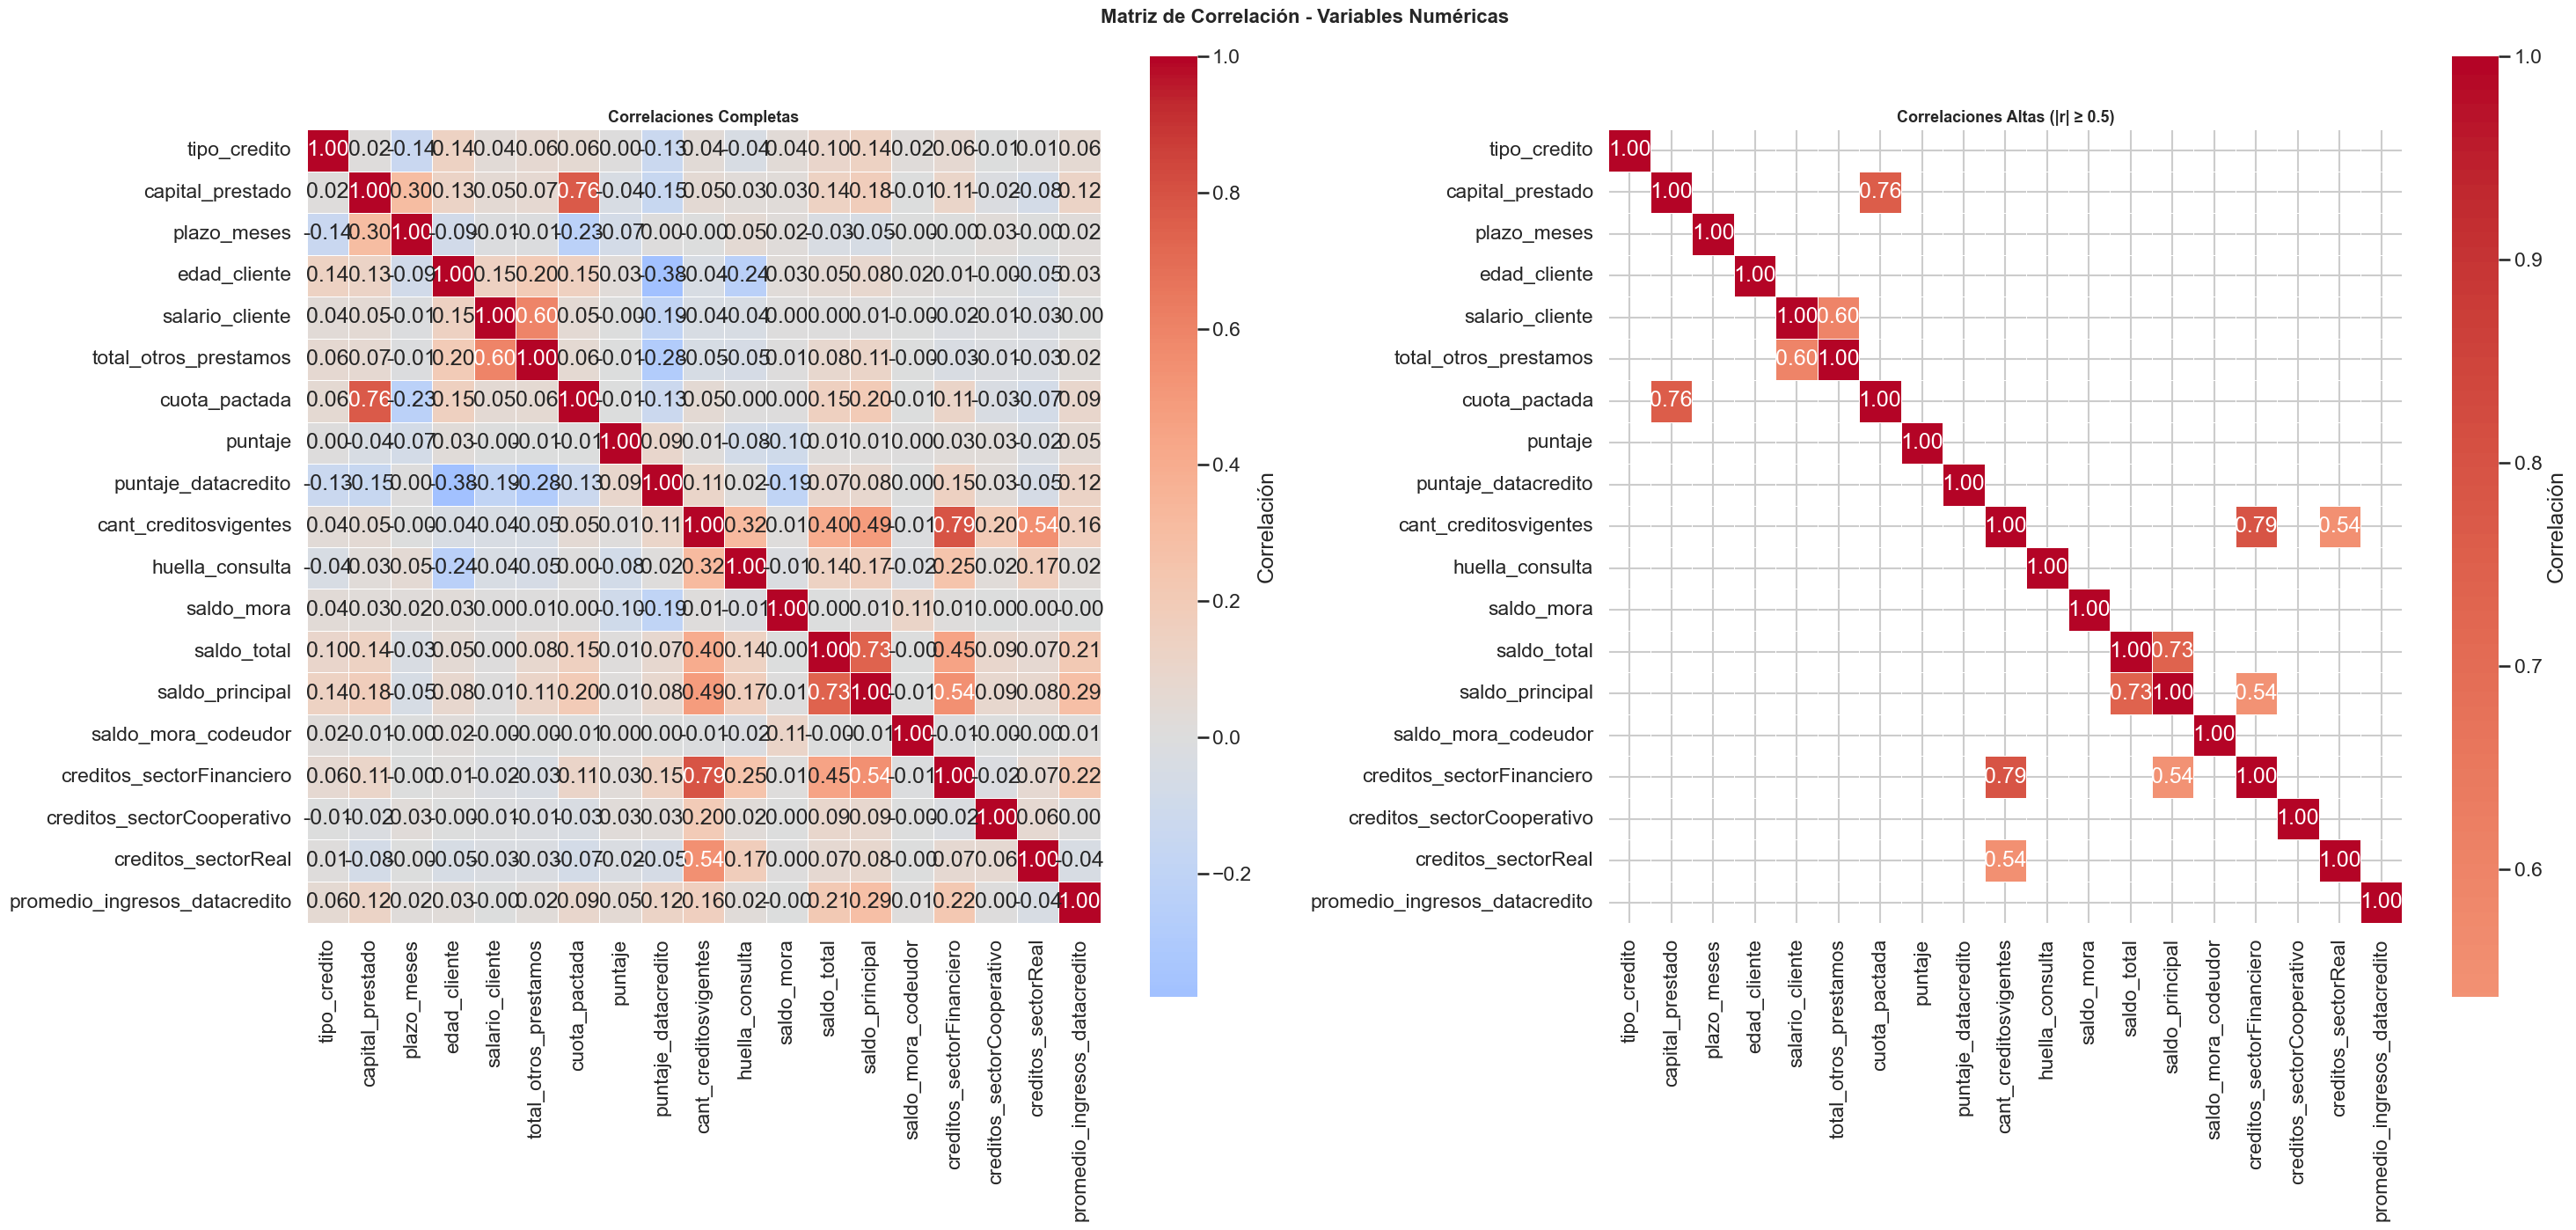


🔍 IDENTIFICACIÓN DE CORRELACIONES ALTAS (|r| ≥ 0.8):
--------------------------------------------------------------------------------
   ✓ No se encontraron correlaciones extremadamente altas (|r| ≥ 0.8)
--------------------------------------------------------------------------------

 CORRELACIONES CON EL TARGET (Pago_atiempo):
--------------------------------------------------------------------------------

   Top 10 correlaciones positivas:
   puntaje                             r =  0.923
   puntaje_datacredito                 r =  0.068
   promedio_ingresos_datacredito       r =  0.040
   edad_cliente                        r =  0.032
   creditos_sectorFinanciero           r =  0.021
   creditos_sectorCooperativo          r =  0.021
   saldo_total                         r =  0.014
   saldo_principal                     r =  0.011
   cant_creditosvigentes               r =  0.009
   saldo_mora_codeudor                 r =  0.003

   Top 10 correlaciones negativas:
   saldo_mora_c

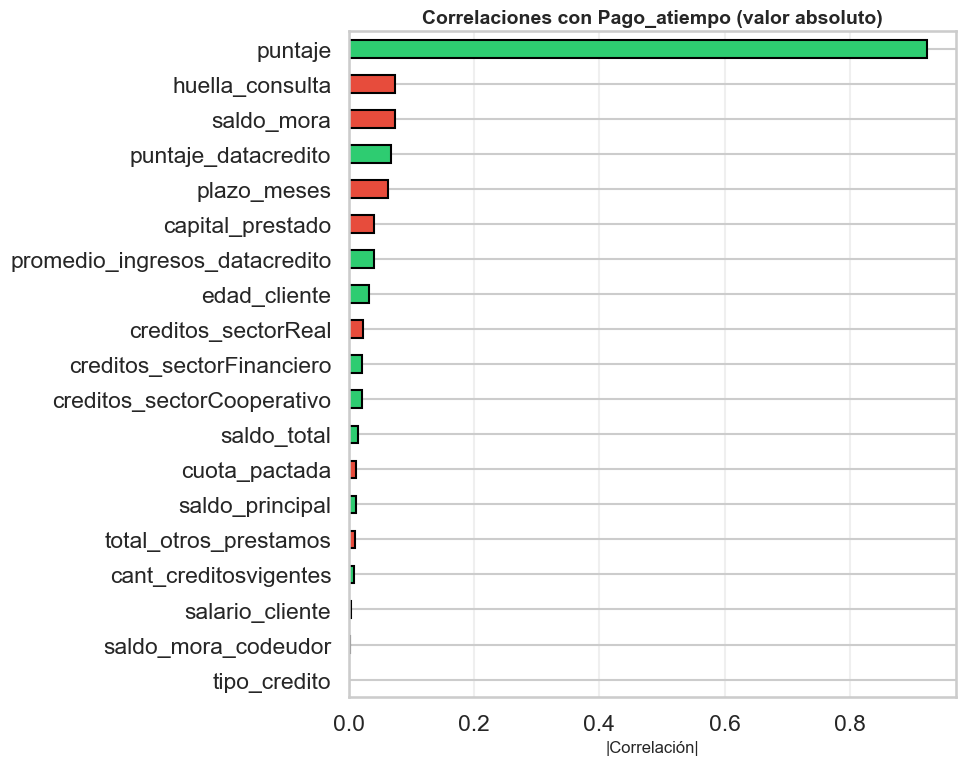

In [45]:
# ============================================
#    MATRIZ DE CORRELACIÓN COMPLETA
# ============================================

import numpy as np

print("="*80)
print(" ANÁLISIS DE CORRELACIONES")
print("="*80)

# Seleccionar solo variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluir el target temporalmente para análisis
if 'Pago_atiempo' in numeric_cols:
    numeric_cols_sin_target = [col for col in numeric_cols if col != 'Pago_atiempo']
else:
    numeric_cols_sin_target = numeric_cols

print(f"\nVariables numéricas para análisis: {len(numeric_cols_sin_target)}")

# Calcular matriz de correlación
correlation_matrix = df[numeric_cols_sin_target].corr()

# Visualización mejorada
fig, axes = plt.subplots(1, 2, figsize=(30, 14))  #*****
fig.suptitle('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold')

# Heatmap completo
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, ax=axes[0],
            cbar_kws={'label': 'Correlación'})
axes[0].set_title('Correlaciones Completas', fontsize=13, fontweight='bold')

# Heatmap solo correlaciones altas (|r| > 0.5)
mask_high = np.abs(correlation_matrix) < 0.5
correlation_high = correlation_matrix.copy()
correlation_high[mask_high] = np.nan

sns.heatmap(correlation_high, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, ax=axes[1],
            cbar_kws={'label': 'Correlación'})
axes[1].set_title('Correlaciones Altas (|r| ≥ 0.5)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Identificar correlaciones altas
print(f"\n🔍 IDENTIFICACIÓN DE CORRELACIONES ALTAS (|r| ≥ 0.8):")
print("-"*80)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) >= 0.8:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            high_corr_pairs.append((var1, var2, corr_val))
            print(f"   {var1:30} <--> {var2:30}  r = {corr_val:>6.3f}")

if not high_corr_pairs:
    print("   ✓ No se encontraron correlaciones extremadamente altas (|r| ≥ 0.8)")

print("-"*80)

# Correlaciones con el target
if 'Pago_atiempo' in df.columns:
    print(f"\n CORRELACIONES CON EL TARGET (Pago_atiempo):")
    print("-"*80)
    
    target_corr = df[numeric_cols].corr()['Pago_atiempo'].sort_values(ascending=False)
    target_corr = target_corr[target_corr.index != 'Pago_atiempo']  # Excluir autocorrelación
    
    # Mostrar top correlaciones
    print("\n   Top 10 correlaciones positivas:")
    for var, corr in target_corr.head(10).items():
        print(f"   {var:35} r = {corr:>6.3f}")
    
    print("\n   Top 10 correlaciones negativas:")
    for var, corr in target_corr.tail(10).items():
        print(f"   {var:35} r = {corr:>6.3f}")
    
    print("-"*80)
    
    # Visualizar correlaciones con target
    fig, ax = plt.subplots(figsize=(10, 8))
    target_corr_abs = target_corr.abs().sort_values(ascending=True)
    colors = ['#e74c3c' if target_corr[var] < 0 else '#2ecc71' for var in target_corr_abs.index]
    
    target_corr_abs.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
    ax.set_title('Correlaciones con Pago_atiempo (valor absoluto)', fontsize=14, fontweight='bold')
    ax.set_xlabel('|Correlación|', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)


In [46]:
# ============================================
# 7.2 DETECCIÓN DE MULTICOLINEALIDAD
# ============================================

print("="*80)
print(" ANÁLISIS DE MULTICOLINEALIDAD")
print("="*80)

print(f"\n VARIABLES CON ALTA CORRELACIÓN (Candidatas a eliminar):")
print("-"*80)

if high_corr_pairs:
    print(f"\nSe encontraron {len(high_corr_pairs)} pares con |r| ≥ 0.8:")
    print()
    
    for var1, var2, corr in high_corr_pairs:
        print(f"   🔴 {var1} <--> {var2}")
        print(f"      Correlación: {corr:.3f}")
        print(f"      Acción sugerida: Eliminar una de las dos en feature engineering")
        print()
    
    # Análisis de qué eliminar
    print(f"\n RECOMENDACIONES:")
    print(f"   Para cada par de variables altamente correlacionadas:")
    print(f"   1. Elegir la que tiene MAYOR correlación con el target")
    print(f"   2. Elegir la que tiene más sentido de negocio")
    print(f"   3. Eliminar la otra en el Avance-2 (feature engineering)")
    
    # Análisis automático
    if 'Pago_atiempo' in df.columns:
        print(f"\n   Análisis automático (basado en correlación con target):")
        target_corr = df[numeric_cols].corr()['Pago_atiempo']
        
        for var1, var2, corr in high_corr_pairs:
            corr_var1 = abs(target_corr.get(var1, 0))
            corr_var2 = abs(target_corr.get(var2, 0))
            
            if corr_var1 > corr_var2:
                print(f"   • Mantener: {var1} (|r|={corr_var1:.3f})")
                print(f"     Eliminar: {var2} (|r|={corr_var2:.3f})")
            else:
                print(f"   • Mantener: {var2} (|r|={corr_var2:.3f})")
                print(f"     Eliminar: {var1} (|r|={corr_var1:.3f})")
            print()

else:
    print("\n✓ No se detectó multicolinealidad severa (|r| ≥ 0.8)")
    print("  Las variables son relativamente independientes entre sí.")

print("="*80)

 ANÁLISIS DE MULTICOLINEALIDAD

 VARIABLES CON ALTA CORRELACIÓN (Candidatas a eliminar):
--------------------------------------------------------------------------------

✓ No se detectó multicolinealidad severa (|r| ≥ 0.8)
  Las variables son relativamente independientes entre sí.


 PAIRPLOT: RELACIONES ENTRE VARIABLES CLAVE

Generando pairplot con 6 variables...
Variables: capital_prestado, puntaje, puntaje_datacredito, edad_cliente, cant_creditosvigentes, Pago_atiempo


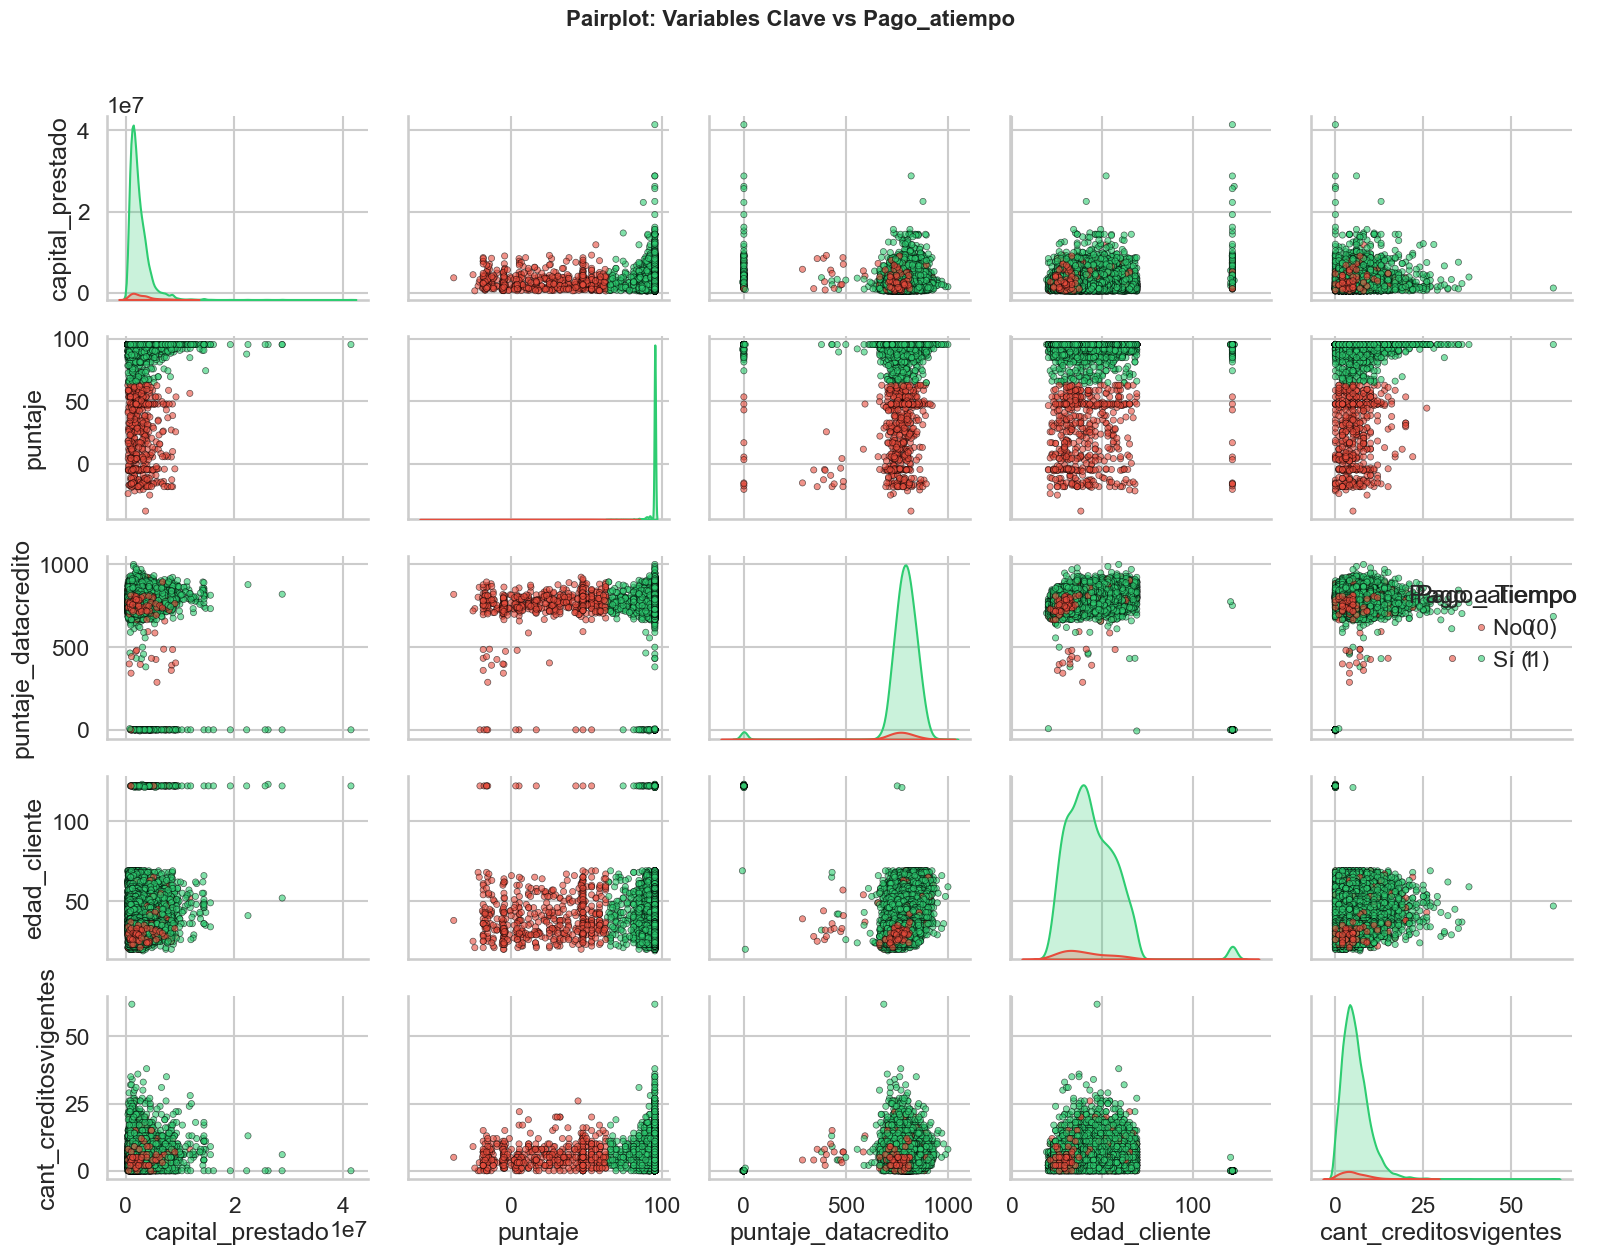


✓ Pairplot generado

 INTERPRETACIÓN:
   • Busca patrones de separación entre colores (rojo vs verde)
   • Variables que separan bien las clases son más predictivas
   • Patrones diagonales indican correlación entre variables


In [47]:
# ============================================
#    PAIRPLOT DE VARIABLES MÁS IMPORTANTES
# ============================================

print("="*80)
print(" PAIRPLOT: RELACIONES ENTRE VARIABLES CLAVE")
print("="*80)

# Seleccionar las variables más relevantes
# (Las que mostraron significancia estadística + algunas clave)
variables_clave = [
    'capital_prestado',
    'puntaje',
    'puntaje_datacredito',
    'edad_cliente',
    'cant_creditosvigentes',
    'Pago_atiempo'
]

# Verificar que existan
variables_clave = [v for v in variables_clave if v in df.columns]

if len(variables_clave) >= 3:
    print(f"\nGenerando pairplot con {len(variables_clave)} variables...")
    print(f"Variables: {', '.join(variables_clave)}")
    
    # Crear pairplot
    g = sns.pairplot(df[variables_clave], 
                    hue='Pago_atiempo',
                    palette={0: '#e74c3c', 1: '#2ecc71'},
                    diag_kind='kde',
                    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'black', 'linewidth': 0.5},
                    height=2.5)
    
    g.fig.suptitle('Pairplot: Variables Clave vs Pago_atiempo', 
                fontsize=16, fontweight='bold', y=1.01)
    
    # Añadir leyenda personalizada
    g.add_legend(title='Pago a Tiempo', labels=['No (0)', 'Sí (1)'])
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Pairplot generado")
    print("\n INTERPRETACIÓN:")
    print("   • Busca patrones de separación entre colores (rojo vs verde)")
    print("   • Variables que separan bien las clases son más predictivas")
    print("   • Patrones diagonales indican correlación entre variables")

else:
    print(f"\n No hay suficientes variables para pairplot")

print("="*80)

## 7. Transformaciones Propuestas y Reglas de Validación

In [48]:
# Identificar transformaciones necesarias
transformaciones = []

# Basado en distribuciones
for col in num_cols:
    if col != target and col in df.columns:
        skewness = df[col].skew()
        if abs(skewness) > 1:
            transformaciones.append(f"Log transform para {col} (skewness: {skewness:.2f})")

# Basado en rangos
for col in num_cols:
    if col != target and col in df.columns:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        outliers = ((df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))).sum()
        if outliers > 0:
            transformaciones.append(f"Tratar outliers en {col} ({outliers} registros)")

# Creación de nuevas features sugeridas
if 'salario_cliente' in df.columns and 'cuota_pactada' in df.columns:
    transformaciones.append("Crear feature: ratio_cuota_ingreso = cuota_pactada / salario_cliente")

if 'capital_prestado' in df.columns and 'salario_cliente' in df.columns:
    transformaciones.append("Crear feature: ratio_prestamo_ingreso = capital_prestado / salario_cliente")

print("TRANSFORMACIONES PROPUESTAS:")
for t in transformaciones[:8]:
    print(f"  • {t}")

TRANSFORMACIONES PROPUESTAS:
  • Log transform para tipo_credito (skewness: 2.67)
  • Log transform para capital_prestado (skewness: 3.72)
  • Log transform para plazo_meses (skewness: 2.46)
  • Log transform para edad_cliente (skewness: 1.93)
  • Log transform para salario_cliente (skewness: 43.78)
  • Log transform para total_otros_prestamos (skewness: 38.46)
  • Log transform para cuota_pactada (skewness: 3.79)
  • Log transform para puntaje (skewness: -4.87)


## 8. Conclusiones del Análisis

In [49]:
print("=" * 60)
print("CONCLUSIONES DEL ANÁLISIS EXPLORATORIO")
print("=" * 60)

print(f"\nRESUMEN GENERAL:")
print(f"- Registros analizados: {len(df):,}")
print(f"- Variables numéricas: {len(num_cols)}")
print(f"- Variables categóricas: {len(cat_cols)}")
print(f"- Valores nulos totales: {df.isnull().sum().sum()}")

if target:
    print(f"\nVARIABLE OBJETIVO ({target}):")
    print(f"- Tasa de incumplimiento: {df[target].mean():.2%}")
    print(f"- Clase minoritaria: {df[target].value_counts().min():,} registros")

print(f"\nTRANSFORMACIONES PRINCIPALES:")
for t in transformaciones[:5]:
    print(f"  • {t}")

if target and target in num_cols and 'corr_matrix' in locals():
    print(f"\nVARIABLES MÁS RELEVANTES (correlación con {target}):")
    top_vars = corr_matrix[target].drop(target).abs().sort_values(ascending=False).head(3)
    for var, corr in top_vars.items():
        direction = "positiva" if corr_matrix.loc[var, target] > 0 else "negativa"
        print(f"  • {var}: {corr_matrix.loc[var, target]:.3f} ({direction})")

print(f"\nPRÓXIMOS PASOS:")
print("  1. Ejecutar feature engineering (ft_engineering.py)")
print("  2. Entrenar modelo baseline (model_training_evaluation.py)")
print("  3. Validar reglas de negocio identificadas")

print("\n" + "=" * 60)
print("EDA COMPLETADO")
print("=" * 60)

# %% [code]
# Mostrar muestra final de datos
df.head()


CONCLUSIONES DEL ANÁLISIS EXPLORATORIO

RESUMEN GENERAL:
- Registros analizados: 10,763
- Variables numéricas: 20
- Variables categóricas: 2
- Valores nulos totales: 7233

VARIABLE OBJETIVO (Pago_atiempo):
- Tasa de incumplimiento: 95.25%
- Clase minoritaria: 511 registros

TRANSFORMACIONES PRINCIPALES:
  • Log transform para tipo_credito (skewness: 2.67)
  • Log transform para capital_prestado (skewness: 3.72)
  • Log transform para plazo_meses (skewness: 2.46)
  • Log transform para edad_cliente (skewness: 1.93)
  • Log transform para salario_cliente (skewness: 43.78)

VARIABLES MÁS RELEVANTES (correlación con Pago_atiempo):
  • puntaje: 0.923 (positiva)
  • huella_consulta: -0.074 (negativa)
  • saldo_mora: -0.073 (negativa)

PRÓXIMOS PASOS:
  1. Ejecutar feature engineering (ft_engineering.py)
  2. Entrenar modelo baseline (model_training_evaluation.py)
  3. Validar reglas de negocio identificadas

EDA COMPLETADO


tipo_credito      fecha_prestamo  capital_prestado  plazo_meses  \
0             7 2024-12-21 11:31:35         3692160.0           10   
1             4 2025-04-22 09:47:35          840000.0            6   
2             9 2026-01-08 12:22:40         5974028.4           10   
3             4 2025-08-04 12:04:10         1671240.0            6   
4             9 2025-04-26 11:24:26         2781636.0           11   

   edad_cliente   tipo_laboral  salario_cliente  total_otros_prestamos  \
0            42  Independiente          8000000                2500000   
1            60       Empleado          3000000                2000000   
2            36  Independiente          4036000                 829000   
3            48       Empleado          1524547                 498000   
4            44       Empleado          5000000                4000000   

   cuota_pactada    puntaje  ...  saldo_mora  saldo_total  saldo_principal  \
0         341296  88.768094  ...         0.0      51258.0          51258.0   
1         124876  95.227787  ...         0.0       8673.0           8673.0   
2         529554  47.613894  ...         0.0      18702.0          18702.0   
3         252420  95.227787  ...         0.0      15782.0          15782.0   
4         217037  95.227787  ...         0.0     204804.0         204804.0   

   saldo_mora_codeudor  creditos_sectorFinanciero  creditos_sectorCooperativo  \
0                  0.0                          5                           0   
1                  0.0                          0                           0   
2                  0.0                          3                           0   
3                  0.0                          3                           0   
4                  0.0                          3                           0   

   creditos_sectorReal  promedio_ingresos_datacredito  tendencia_ingresos  \
0                    0                       908526.0             Estable   
1                    2                       939017.0           Creciente   
2                    0                            NaN                 NaN   
3                    0                      1536193.0           Creciente   
4                    1                       933473.0           Creciente   

   Pago_atiempo  
0             1  
1             1  
2             0  
3             1  
4             1  

[5 rows x 23 columns]